In [16]:
pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 884.0 kB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
from river import stream,tree,metrics
import utils
from encoding import prefix_bin
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
from tqdm import tqdm
import pickle as pkl
import matplotlib.pyplot as plt
import os,json
import datetime
from collections import deque
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
import utils
import sliding_window

import warnings

warnings.filterwarnings("ignore")
import xgboost as xgb

import datetime, time
import importlib
importlib.reload(sliding_window)

<module 'sliding_window' from '/home/aboughas/online_ppm_stability/expereiment/sliding_window.py'>

In [6]:
def display_progress(row_counting, total_length, interval=2000):
    if rowcounter%interval == 0:
        print(round(rowcounter*100/totallength,2) ,'%', 'Case finished: %s'%(casecount), 'Running cases: %s'%(len(streaming_db)))

In [8]:
def update_test_cases(new_case, test_cases):
    test_cases.append(new_case)
    if len(test_cases) > test_size:
        test_cases.popleft()

In [10]:
# Experiment settings
dataset_label = 'bpic17'

# Invoke parameters for dataset
with open('../dataset_parameters.json','r') as json_file:
    parameters = json.load(json_file)[dataset_label]
    print(parameters)
    key_pair = parameters['key_pair']
    catatars = parameters['categorical_attrs']
    maximum_prefixs = parameters['maximum_prefix']

{'key_pair': {'Case ID': 'caseid', 'Activity': 'activity', 'Resource': 'resource', 'Start Timestamp': 'ts'}, 'categorical_attrs': ['activity', 'resource'], 'maximum_prefix': 15}


In [36]:
'''
Before test and training streaming event predictive monitoring, grace period is preceded to initialize model by prefix length
and obtain feature matrix to transform future events
'''


for maximum_prefix in range(1, maximum_prefixs+1):
    print(maximum_prefix)
    performance_measure_type = 'ROCAUC'
    dataset_loc = '../DATA/logs/'+ dataset_label +'.csv'
    try:
        os.makedirs('../result/%s'%(dataset_label))
    except:
        pass

    # Set streaming classifier
    classifier = 'xgb'
    if classifier == 'xgb':
        streaming_classifier = xgb.XGBClassifier(n_estimators = 100, learning_rate=0.01, verbosity =0)

    streaming_db ={}
    training_models ={}
    test_cases = deque()
    feature_matrix ={}

    casecount = 0
    rowcounter = 0
    running_case = 0
    prediction_result = dict()
    for i in range(1, maximum_prefix+1): prediction_result[i] = {}
    finished_caseid = set()
    
    # Sliding window for training setting
    window_size = 100
    test_size = 30
    training_windows = sliding_window.training_window(window_size,test_size)
    training_models['prefix_%s'%(maximum_prefix)] = [streaming_classifier, 0]
    
    dataset = stream.iter_csv(
            dataset_loc
            )
    totallength = len(list(dataset))

    dataset = stream.iter_csv(
                dataset_loc,
                target='outcome'
                )
    enctype = 'Index-base'
    
    cdhappend ={}
    for i in range(1, maximum_prefix+1): cdhappend[i] = 0

    for x,y in dataset:
        rowcounter +=1
        # Event stream change dictionary keys
        x = utils.dictkey_chg(x, key_pair)

        if dataset_label !='bpic15':
            x['ts'] = x['ts'][:-4]

        x['outcome'] =y 
        # Initialize case by prefix length
        caseid = x['caseid']
        outcome = x['outcome']
    #     progress = x['progress']

        x.pop('caseid')
        x.pop('outcome')

    #     x.pop('progress')

        case_bin = prefix_bin(caseid, x)
        case_bin.set_enctype(enctype)

        if caseid not in list(streaming_db.keys()):
            case_bin.set_prefix_length(1)    
            streaming_db[caseid] = []
        elif caseid in finished_caseid:
            pass
        else:
            case_bin.set_prefix_length(len(streaming_db[caseid])+1)
            case_bin.set_prev_enc(streaming_db[caseid][-1])

        # Encode event and cases and add to DB
        case_bin.update_truelabel(outcome)   
        case_bin.update_encoded(catattrs=catatars,enctype=enctype)
        ts = case_bin.event['ts']
        streaming_db[caseid].append(case_bin)
        # Detect label appeared case 
        if outcome != '' and caseid not in finished_caseid:
            for i in streaming_db[caseid]:
                i.update_truelabel(outcome)
            finished_caseid.add(caseid)
            # Adding newly finished case to training set.    
            casecount +=1
            # Grace period to collect feature matrix
            case_length = len(streaming_db[caseid])
            if case_length >= maximum_prefix:
                if 'prefix_%s'%(maximum_prefix) not in list(feature_matrix.keys()):
                    feature_matrix['prefix_%s'%(maximum_prefix)]=set()

                case_length = len(streaming_db[caseid])
                if case_length >= maximum_prefix:
                    x = streaming_db[caseid][maximum_prefix-1]
                    training_windows.update_window(x)
                    update_test_cases(streaming_db[caseid], test_cases)

                    if training_windows.retraining_count == test_size:
                        x_training = pd.DataFrame.from_dict([i.encoded for i in training_windows.container])
                        for i in x_training.columns.values: x_training[i] = x_training[i].fillna(0)
                        feature_matrix['prefix_%s'%(maximum_prefix)] = x_training.columns.values
                        y_training = [i.true_label for i in training_windows.container]
                        #print("Unique labels in y_training:", type(y_training))
                        #print("Shape of x_training:", x_training.shape)
                        
                        
                        
                        le = LabelEncoder()
                        y_training = le.fit_transform(y_training)

                        training_models['prefix_%s'%(maximum_prefix)][0].fit(x_training, np.array(y_training))
                        training_models['prefix_%s'%(maximum_prefix)][1] +=1
                        training_windows.reset_retraining_count()

                        '''
                        Evaluate current model with test cases
                        '''
                        model_update_count = training_models['prefix_%s'%(maximum_prefix)][1]
                        prediction_result[maximum_prefix][model_update_count] = {}
                        y_truelist = []
                        y_predlist = []
                        for case in test_cases:
                            if len(case) >= maximum_prefix:
                                x = case[maximum_prefix-1]
                                model = training_models['prefix_%s'%(x.prefix_length)][0]
                                current_event = utils.readjustment_training(x.encoded, feature_matrix['prefix_%s'%(maximum_prefix)])
                                current_event = pd.Series(current_event).to_frame().T
                                y_pred = training_models['prefix_%s'%(x.prefix_length)][0].predict_proba(current_event)
                                y_truelist.append(x.true_label)
                                y_predlist.append(y_pred)

                        prediction_result[maximum_prefix][model_update_count]['y_true'] = y_truelist
                        prediction_result[maximum_prefix][model_update_count]['y_pred'] = y_predlist
                        if 'b1' not in caseid and cdhappend[maximum_prefix] == 0:
                            cdhappend[maximum_prefix] = model_update_count
    for evaluation_method in ['Accuracy', 'F1', 'ROCAUC']:
        prefix = maximum_prefix
        update_count =[]
        evaluation_list = []
        length_list = []
        for update in prediction_result[prefix].keys():
            y_true = prediction_result[prefix][update]['y_true']
            y_pred_prob_ = prediction_result[prefix][update]['y_pred']
            prediction_class = training_models['prefix_%s'%(maximum_prefix)][0].classes_
            if len(prediction_class) == 1: prediction_class = ['False', 'True']
            y_pred_prob = []
            for i in y_pred_prob_:
                y_pred_prob.append({prediction_class[0]: i[0][0], prediction_class[1]: i[0][1]})
            y_pred = [max(x, key=x.get) for x in y_pred_prob]
            update_count.append(update)

            if evaluation_method =='Accuracy':
                value = accuracy_score(y_true, y_pred)
            elif evaluation_method =='F1':
                conv_y_pred = ['True' if pred == 1 else 'False' for pred in y_pred]
                value = f1_score(y_true, conv_y_pred, average='macro')

            elif evaluation_method =='ROCAUC':
                print(y_pred_prob)
                try:
                    y_pred_prob = np.array([[x[0], x[1]] for x in y_pred_prob])
                    try:
                        value = roc_auc_score(y_true, y_pred_prob[:, 1])
                    except:
                        value = 0
                except:
                    y_pred_prob = np.array([[x['False'], x['True']] for x in y_pred_prob])
                    try:
                        value = roc_auc_score(y_true, y_pred_prob[:, 1])
                    except:
                        value = 0
            evaluation_list.append(value)
        plt.figure(figsize=(15,8))
        plt.plot(update_count, evaluation_list, label = 'Accuracy')
        #     plt.plot(update_count, length_list)
        if dataset_label == 'bpic15' or dataset_label == 'bpic17':
            pass
        else:
            plt.axvline(cdhappend[prefix], color = 'black', linestyle ='--', label = 'Concept drift')
        plt.title(prefix)
        plt.xlabel('Model update count')
        plt.legend(bbox_to_anchor=(0.65, -0.1), ncol=2)
        plt.ylim(0,1)

        if os.path.exists('../img/%s/%s/%s'%(dataset_label, classifier, 'Model updates')) == False:
            os.makedirs('../img/%s/%s/%s'%(dataset_label, classifier, 'Model updates'))
        if os.path.exists('../result/%s/%s/%s'%(dataset_label, classifier, 'Model updates')) == False:
            os.makedirs('../result/%s/%s/%s'%(dataset_label, classifier, 'Model updates'))

        with open('../result/%s/%s/Model updates/prefix_%s_%s update.pkl'%(dataset_label, classifier, prefix, evaluation_method), 'wb') as f:
            pkl.dump(prediction_result, f)
        plt.savefig('../img/%s/%s/Model updates/prefix_%s_%s update.png'%(dataset_label, classifier, prefix, evaluation_method), dpi=250)
        plt.cla()
        plt.clf()
        plt.close()

1
[{0: 0.5, 1: 0.5}, {0: 0.27829802, 1: 0.721702}, {0: 0.5, 1: 0.5}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.5, 1: 0.5}, {0: 0.5, 1: 0.5}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}]
[{0: 0.285317, 1: 0.714683}, {0: 0.285317, 1: 0.714683}, {0: 0.285317, 1: 0.714683}, {0: 0.285317, 1: 0.714683}, {0: 0.285317, 1: 0.714683}, {0: 

In [43]:
# Experiment settings
dataset_label = 'bpic17'

# Invoke parameters for dataset
with open('../dataset_parameters.json','r') as json_file:
    parameters = json.load(json_file)[dataset_label]
    print(parameters)
    key_pair = parameters['key_pair']
    catatars = parameters['categorical_attrs']
    maximum_prefixs = parameters['maximum_prefix']

{'key_pair': {'Case ID': 'caseid', 'Activity': 'activity', 'Resource': 'resource', 'Start Timestamp': 'ts'}, 'categorical_attrs': ['activity', 'resource'], 'maximum_prefix': 15}


{'key_pair': {'Case ID': 'caseid', 'Activity': 'activity', 'Resource': 'resource', 'Start Timestamp': 'ts'}, 'categorical_attrs': ['activity', 'resource'], 'maximum_prefix': 15}
1
{1: {30: {'y_true': ['False', 'False', 'False', 'True', 'True', 'True', 'False', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'True'], 'y_pred': [array([[0.5, 0.5]], dtype=float32), array([[0.27829802, 0.721702  ]], dtype=float32), array([[0.5, 0.5]], dtype=float32), array([[0.27829802, 0.721702  ]], dtype=float32), array([[0.27829802, 0.721702  ]], dtype=float32), array([[0.27829802, 0.721702  ]], dtype=float32), array([[0.27829802, 0.721702  ]], dtype=float32), array([[0.27829802, 0.721702  ]], dtype=float32), array([[0.27829802, 0.721702  ]], dtype=float32), array([[0.27829802, 0.721702  ]], dtype=float32), array([[0.5, 0.5]], dtype=float32), array([[0.5, 0.5]], dtype=float32)

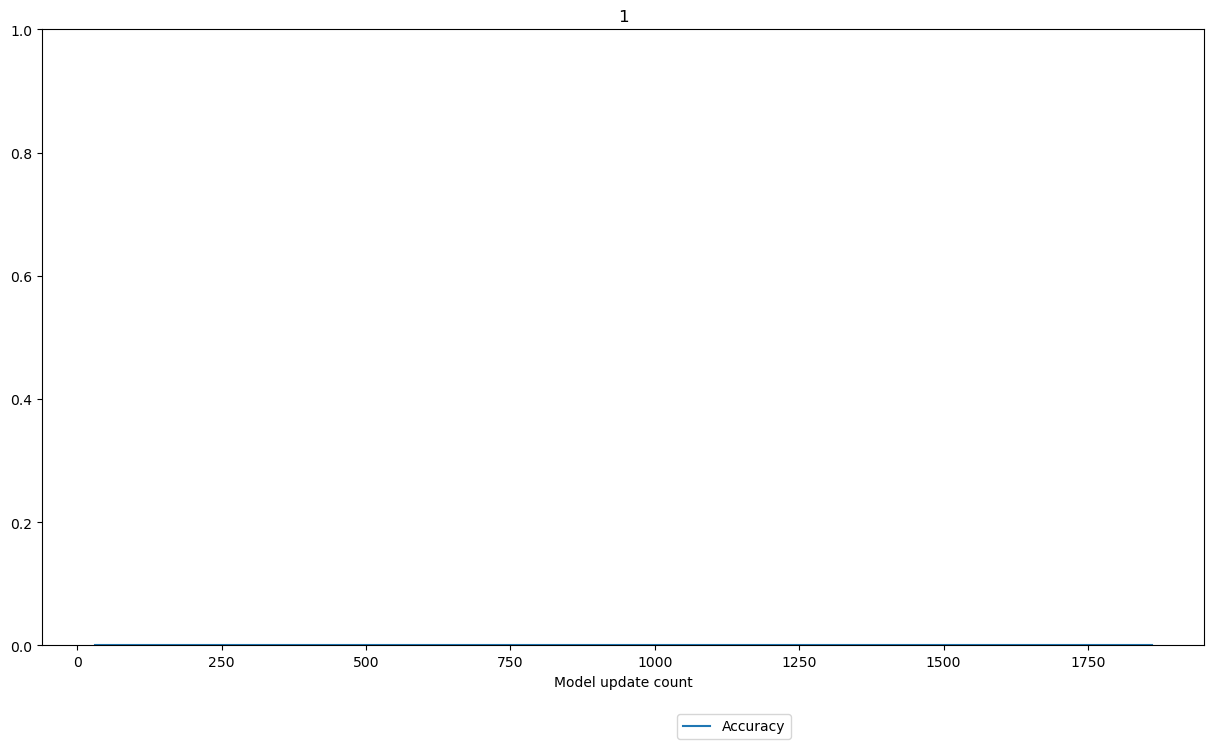

{1: {30: {'y_true': ['False', 'False', 'False', 'True', 'True', 'True', 'False', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'True'], 'y_pred': [array([[0.5, 0.5]], dtype=float32), array([[0.27829802, 0.721702  ]], dtype=float32), array([[0.5, 0.5]], dtype=float32), array([[0.27829802, 0.721702  ]], dtype=float32), array([[0.27829802, 0.721702  ]], dtype=float32), array([[0.27829802, 0.721702  ]], dtype=float32), array([[0.27829802, 0.721702  ]], dtype=float32), array([[0.27829802, 0.721702  ]], dtype=float32), array([[0.27829802, 0.721702  ]], dtype=float32), array([[0.27829802, 0.721702  ]], dtype=float32), array([[0.5, 0.5]], dtype=float32), array([[0.5, 0.5]], dtype=float32), array([[0.27829802, 0.721702  ]], dtype=float32), array([[0.27829802, 0.721702  ]], dtype=float32), array([[0.27829802, 0.721702  ]], dtype=float32), array([[0.27829802, 0.721702

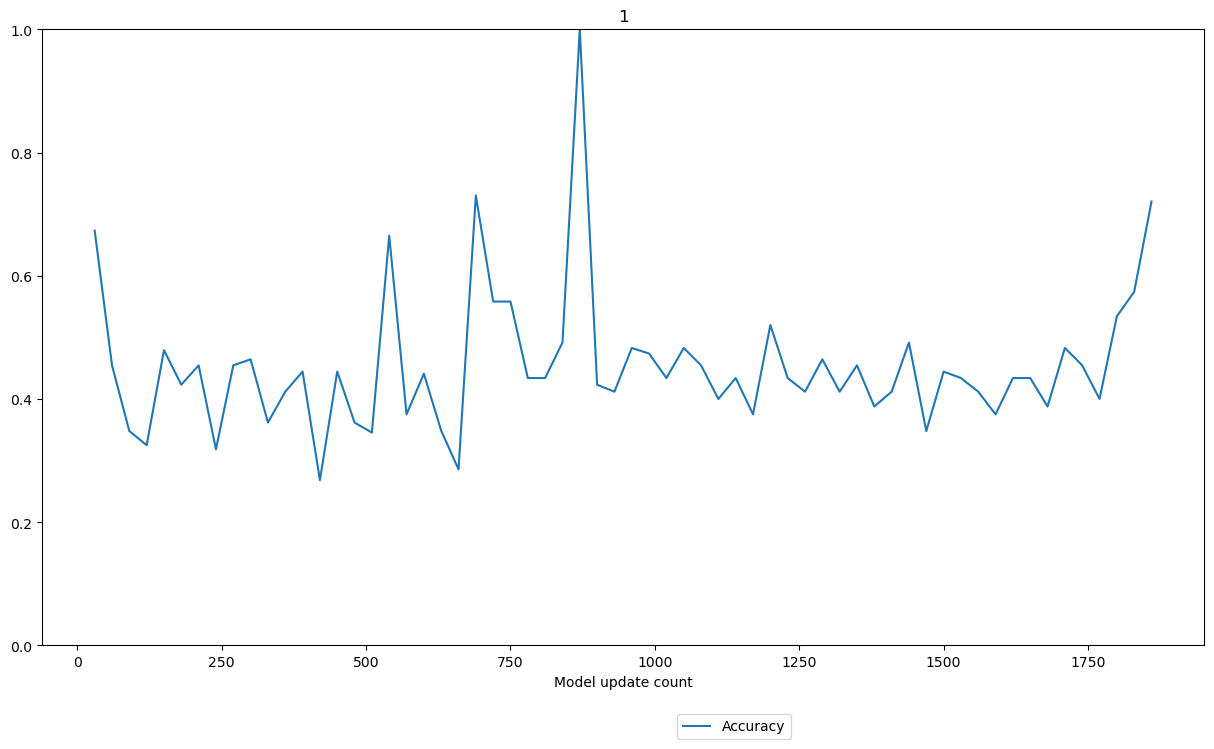

[{0: 0.5, 1: 0.5}, {0: 0.27829802, 1: 0.721702}, {0: 0.5, 1: 0.5}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.5, 1: 0.5}, {0: 0.5, 1: 0.5}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}, {0: 0.27829802, 1: 0.721702}]
[{0: 0.285317, 1: 0.714683}, {0: 0.285317, 1: 0.714683}, {0: 0.285317, 1: 0.714683}, {0: 0.285317, 1: 0.714683}, {0: 0.285317, 1: 0.714683}, {0: 0.

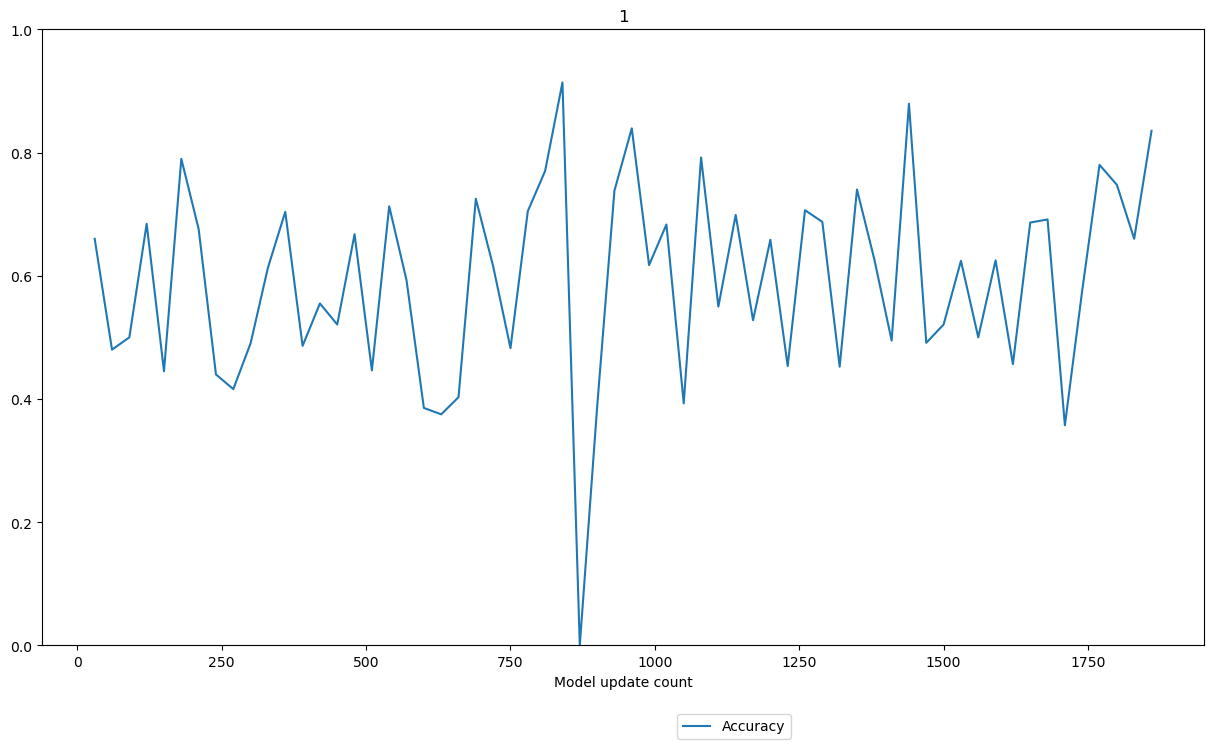

2
{1: {}, 2: {30: {'y_true': ['False', 'False', 'False', 'True', 'True', 'True', 'False', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'True'], 'y_pred': [array([[0.4488719, 0.5511281]], dtype=float32), array([[0.2483995, 0.7516005]], dtype=float32), array([[0.4488719, 0.5511281]], dtype=float32), array([[0.2483995, 0.7516005]], dtype=float32), array([[0.2483995, 0.7516005]], dtype=float32), array([[0.2483995, 0.7516005]], dtype=float32), array([[0.4488719, 0.5511281]], dtype=float32), array([[0.4488719, 0.5511281]], dtype=float32), array([[0.2483995, 0.7516005]], dtype=float32), array([[0.2483995, 0.7516005]], dtype=float32), array([[0.2483995, 0.7516005]], dtype=float32), array([[0.2483995, 0.7516005]], dtype=float32), array([[0.2483995, 0.7516005]], dtype=float32), array([[0.2483995, 0.7516005]], dtype=float32), array([[0.2483995, 0.7516005]], dtype=flo

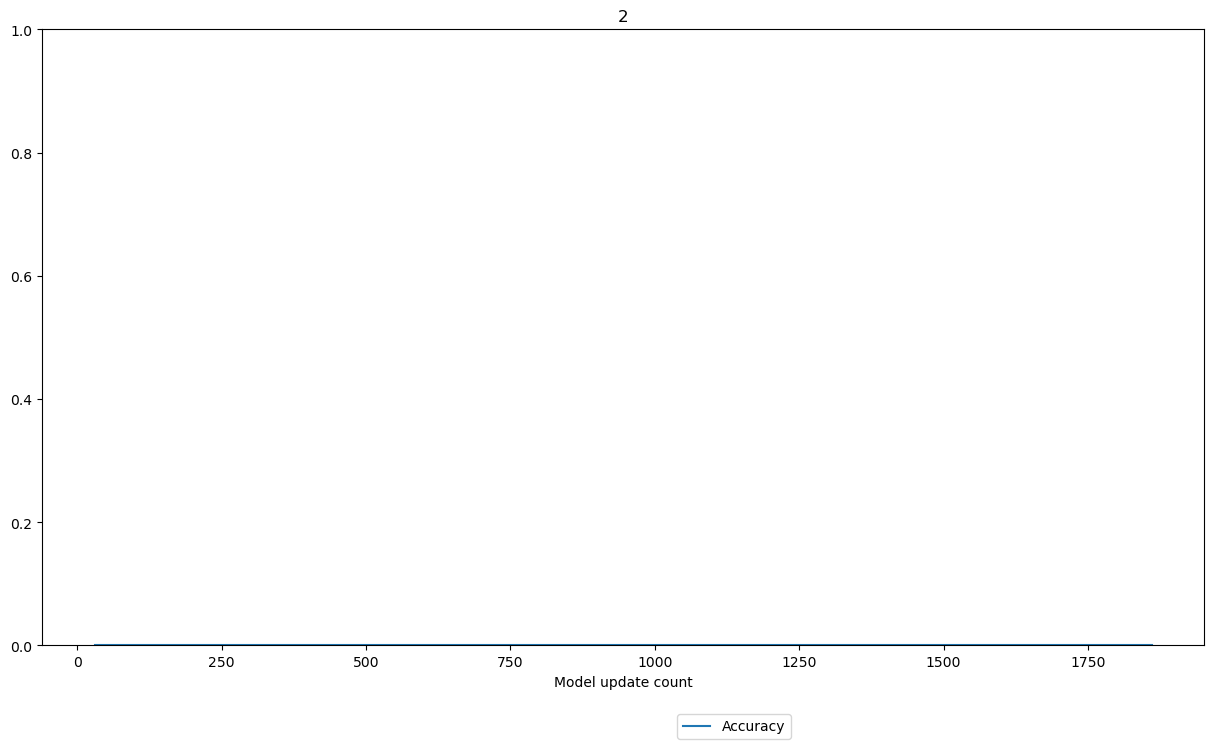

{1: {}, 2: {30: {'y_true': ['False', 'False', 'False', 'True', 'True', 'True', 'False', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'True'], 'y_pred': [array([[0.4488719, 0.5511281]], dtype=float32), array([[0.2483995, 0.7516005]], dtype=float32), array([[0.4488719, 0.5511281]], dtype=float32), array([[0.2483995, 0.7516005]], dtype=float32), array([[0.2483995, 0.7516005]], dtype=float32), array([[0.2483995, 0.7516005]], dtype=float32), array([[0.4488719, 0.5511281]], dtype=float32), array([[0.4488719, 0.5511281]], dtype=float32), array([[0.2483995, 0.7516005]], dtype=float32), array([[0.2483995, 0.7516005]], dtype=float32), array([[0.2483995, 0.7516005]], dtype=float32), array([[0.2483995, 0.7516005]], dtype=float32), array([[0.2483995, 0.7516005]], dtype=float32), array([[0.2483995, 0.7516005]], dtype=float32), array([[0.2483995, 0.7516005]], dtype=float

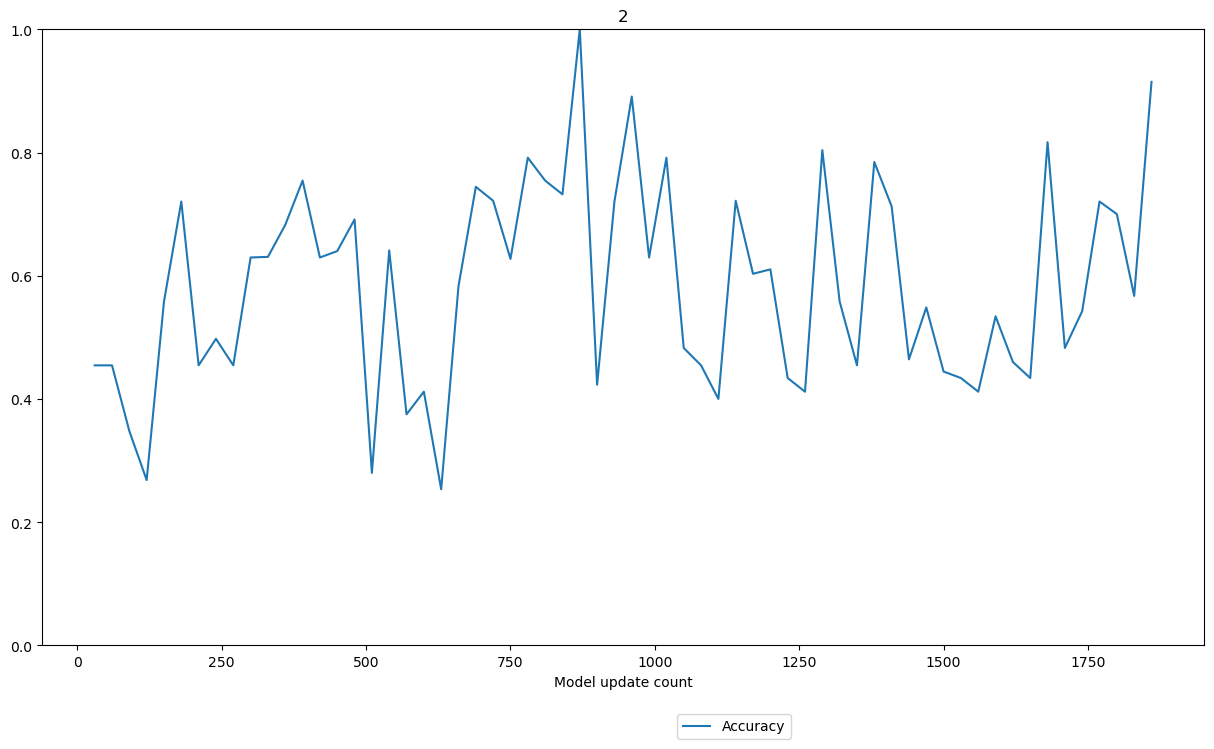

[{0: 0.4488719, 1: 0.5511281}, {0: 0.2483995, 1: 0.7516005}, {0: 0.4488719, 1: 0.5511281}, {0: 0.2483995, 1: 0.7516005}, {0: 0.2483995, 1: 0.7516005}, {0: 0.2483995, 1: 0.7516005}, {0: 0.4488719, 1: 0.5511281}, {0: 0.4488719, 1: 0.5511281}, {0: 0.2483995, 1: 0.7516005}, {0: 0.2483995, 1: 0.7516005}, {0: 0.2483995, 1: 0.7516005}, {0: 0.2483995, 1: 0.7516005}, {0: 0.2483995, 1: 0.7516005}, {0: 0.2483995, 1: 0.7516005}, {0: 0.2483995, 1: 0.7516005}, {0: 0.4488719, 1: 0.5511281}, {0: 0.2483995, 1: 0.7516005}, {0: 0.2483995, 1: 0.7516005}, {0: 0.2483995, 1: 0.7516005}, {0: 0.2483995, 1: 0.7516005}, {0: 0.2483995, 1: 0.7516005}, {0: 0.2483995, 1: 0.7516005}, {0: 0.4488719, 1: 0.5511281}, {0: 0.2483995, 1: 0.7516005}, {0: 0.4488719, 1: 0.5511281}, {0: 0.4488719, 1: 0.5511281}, {0: 0.2483995, 1: 0.7516005}, {0: 0.2483995, 1: 0.7516005}, {0: 0.4488719, 1: 0.5511281}, {0: 0.4488719, 1: 0.5511281}]
[{0: 0.43779898, 1: 0.562201}, {0: 0.43779898, 1: 0.562201}, {0: 0.24468374, 1: 0.75531626}, {0: 0.

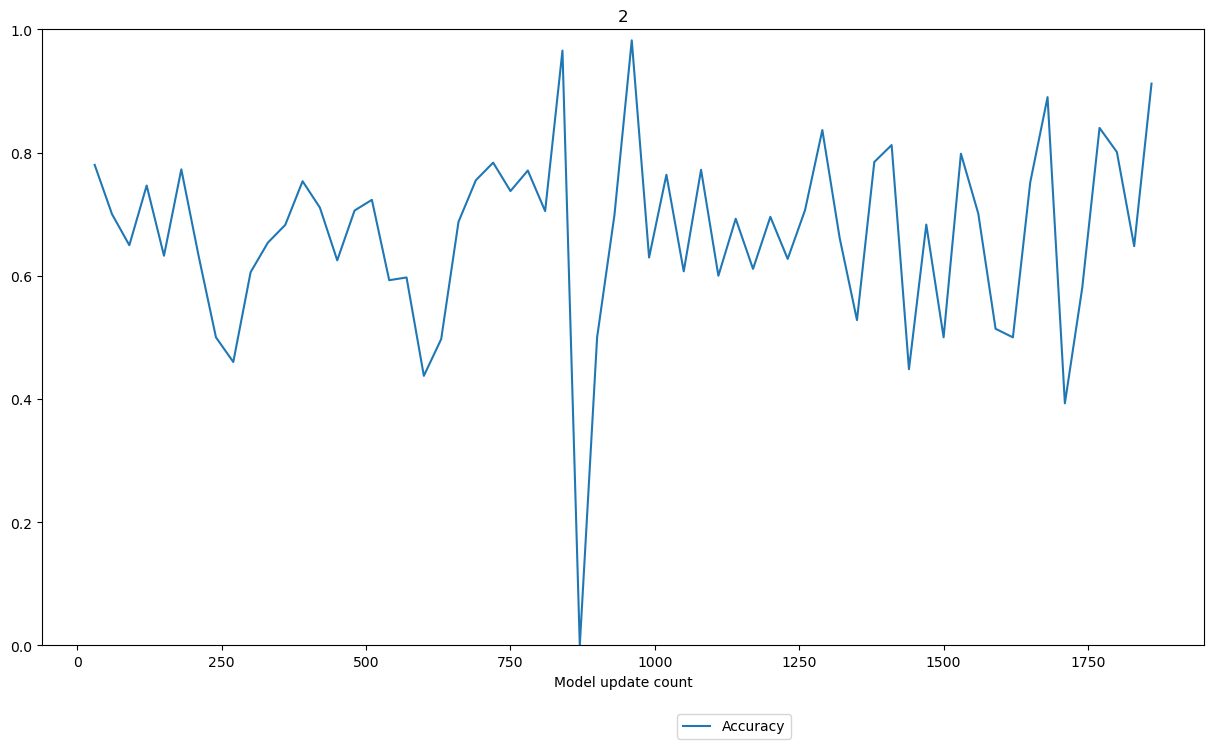

3
{1: {}, 2: {}, 3: {30: {'y_true': ['False', 'False', 'False', 'True', 'True', 'True', 'False', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'True'], 'y_pred': [array([[0.4488719, 0.5511281]], dtype=float32), array([[0.31549639, 0.6845036 ]], dtype=float32), array([[0.4488719, 0.5511281]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.31549639, 0.6845036 ]], dtype=float32), array([[0.4488719, 0.5511281]], dtype=float32), array([[0.4488719, 0.5511281]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.31549639, 0.6845036 ]], dtype=float32), array([[0.2375

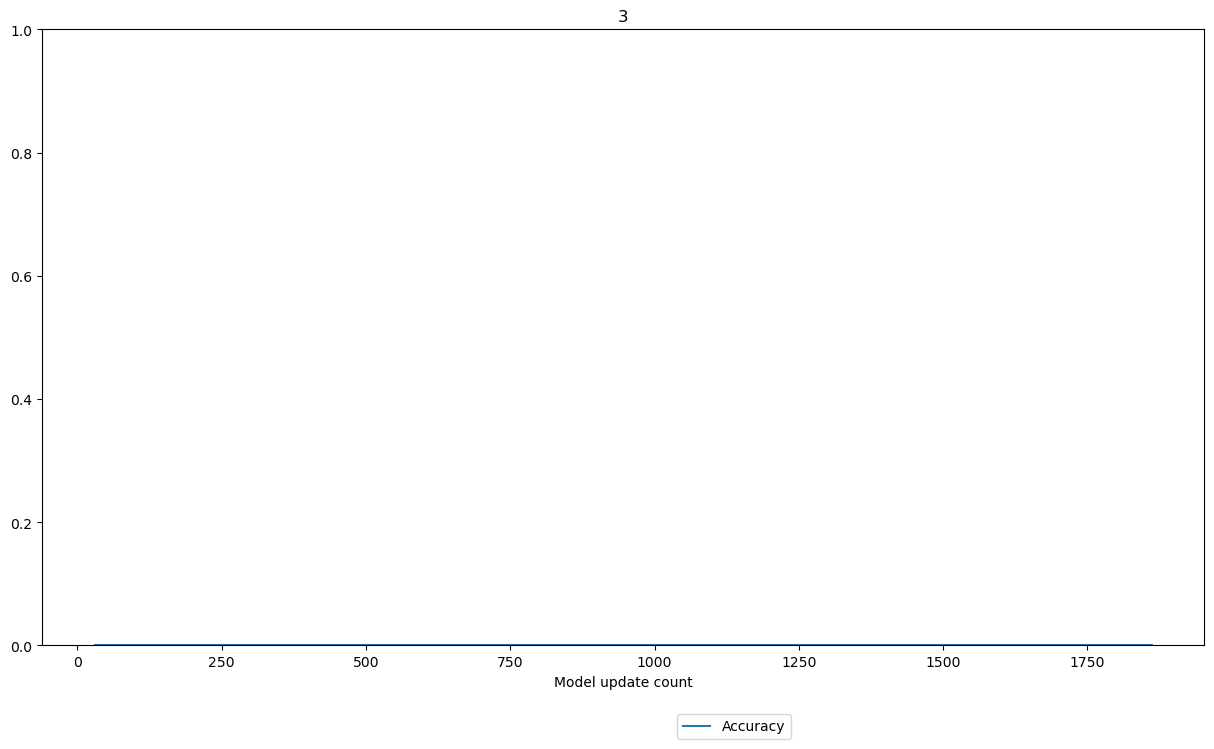

{1: {}, 2: {}, 3: {30: {'y_true': ['False', 'False', 'False', 'True', 'True', 'True', 'False', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'True'], 'y_pred': [array([[0.4488719, 0.5511281]], dtype=float32), array([[0.31549639, 0.6845036 ]], dtype=float32), array([[0.4488719, 0.5511281]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.31549639, 0.6845036 ]], dtype=float32), array([[0.4488719, 0.5511281]], dtype=float32), array([[0.4488719, 0.5511281]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.31549639, 0.6845036 ]], dtype=float32), array([[0.237580

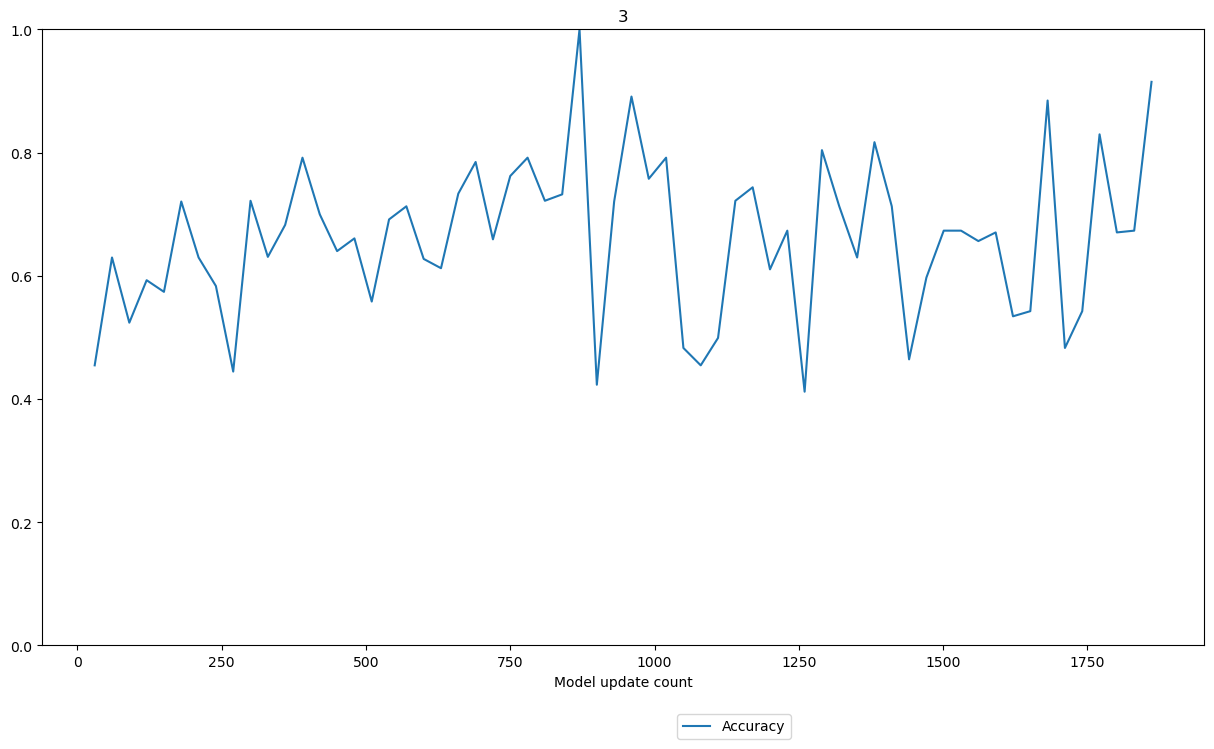

[{0: 0.4488719, 1: 0.5511281}, {0: 0.31549639, 1: 0.6845036}, {0: 0.4488719, 1: 0.5511281}, {0: 0.23758072, 1: 0.7624193}, {0: 0.23758072, 1: 0.7624193}, {0: 0.31549639, 1: 0.6845036}, {0: 0.4488719, 1: 0.5511281}, {0: 0.4488719, 1: 0.5511281}, {0: 0.23758072, 1: 0.7624193}, {0: 0.23758072, 1: 0.7624193}, {0: 0.23758072, 1: 0.7624193}, {0: 0.23758072, 1: 0.7624193}, {0: 0.23758072, 1: 0.7624193}, {0: 0.31549639, 1: 0.6845036}, {0: 0.23758072, 1: 0.7624193}, {0: 0.4488719, 1: 0.5511281}, {0: 0.23758072, 1: 0.7624193}, {0: 0.23758072, 1: 0.7624193}, {0: 0.23758072, 1: 0.7624193}, {0: 0.23758072, 1: 0.7624193}, {0: 0.23758072, 1: 0.7624193}, {0: 0.23758072, 1: 0.7624193}, {0: 0.4488719, 1: 0.5511281}, {0: 0.23758072, 1: 0.7624193}, {0: 0.4488719, 1: 0.5511281}, {0: 0.4488719, 1: 0.5511281}, {0: 0.31549639, 1: 0.6845036}, {0: 0.31549639, 1: 0.6845036}, {0: 0.4488719, 1: 0.5511281}, {0: 0.4488719, 1: 0.5511281}]
[{0: 0.41802543, 1: 0.58197457}, {0: 0.41802543, 1: 0.58197457}, {0: 0.22468525

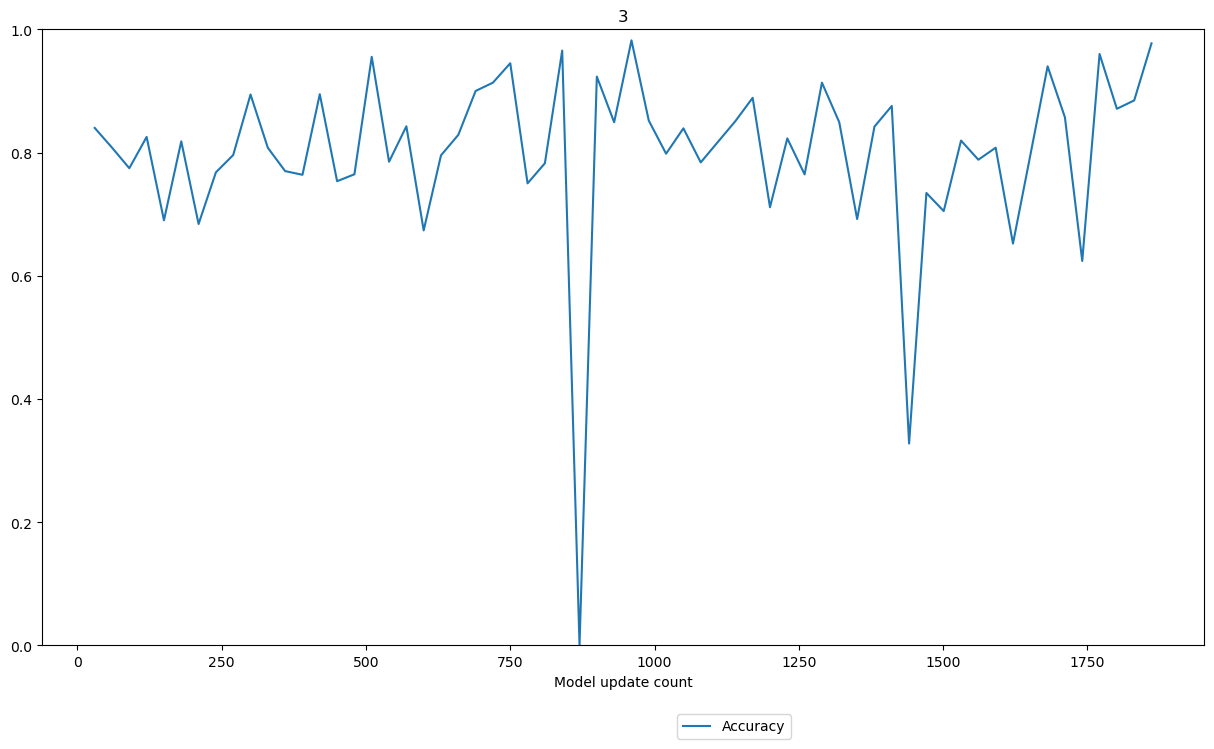

4
{1: {}, 2: {}, 3: {}, 4: {30: {'y_true': ['False', 'False', 'False', 'True', 'True', 'True', 'False', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'True'], 'y_pred': [array([[0.42451853, 0.5754815 ]], dtype=float32), array([[0.31549639, 0.6845036 ]], dtype=float32), array([[0.5, 0.5]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.31549639, 0.6845036 ]], dtype=float32), array([[0.42574054, 0.57425946]], dtype=float32), array([[0.42451853, 0.5754815 ]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.31549639, 0.6845036 ]], dtype=float32), array([[0.237

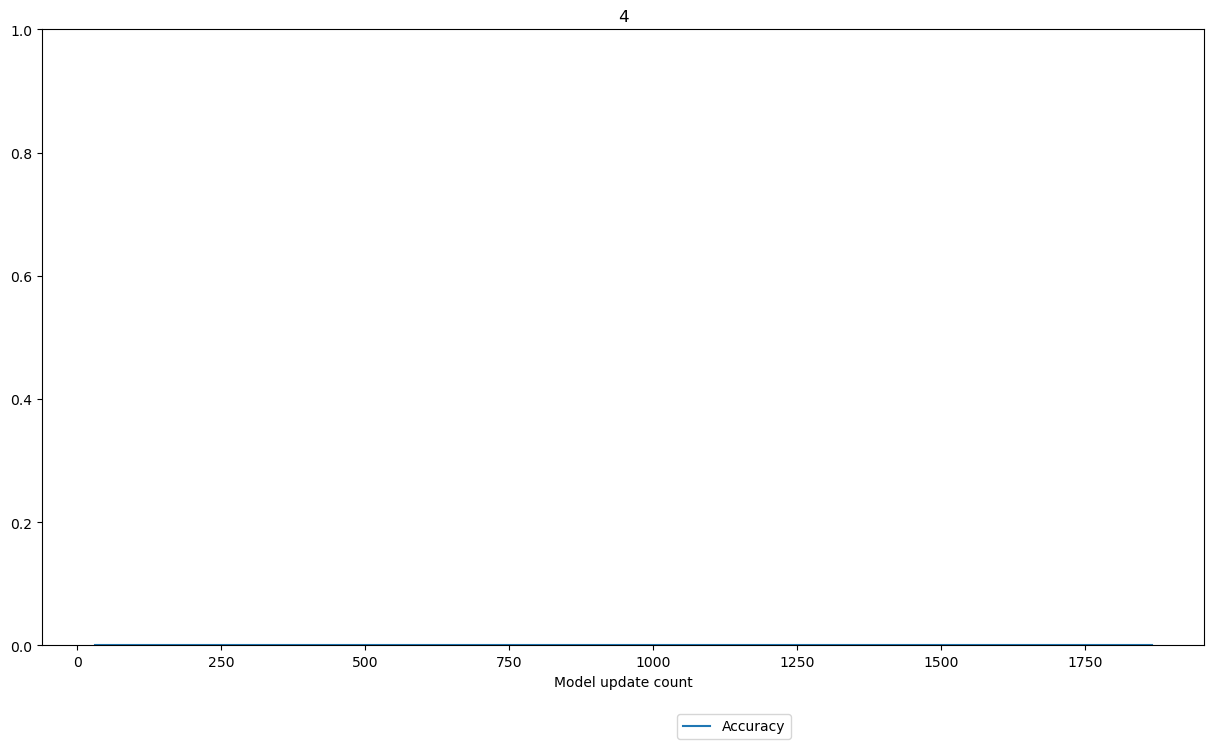

{1: {}, 2: {}, 3: {}, 4: {30: {'y_true': ['False', 'False', 'False', 'True', 'True', 'True', 'False', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'True'], 'y_pred': [array([[0.42451853, 0.5754815 ]], dtype=float32), array([[0.31549639, 0.6845036 ]], dtype=float32), array([[0.5, 0.5]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.31549639, 0.6845036 ]], dtype=float32), array([[0.42574054, 0.57425946]], dtype=float32), array([[0.42451853, 0.5754815 ]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.23758072, 0.7624193 ]], dtype=float32), array([[0.31549639, 0.6845036 ]], dtype=float32), array([[0.23758

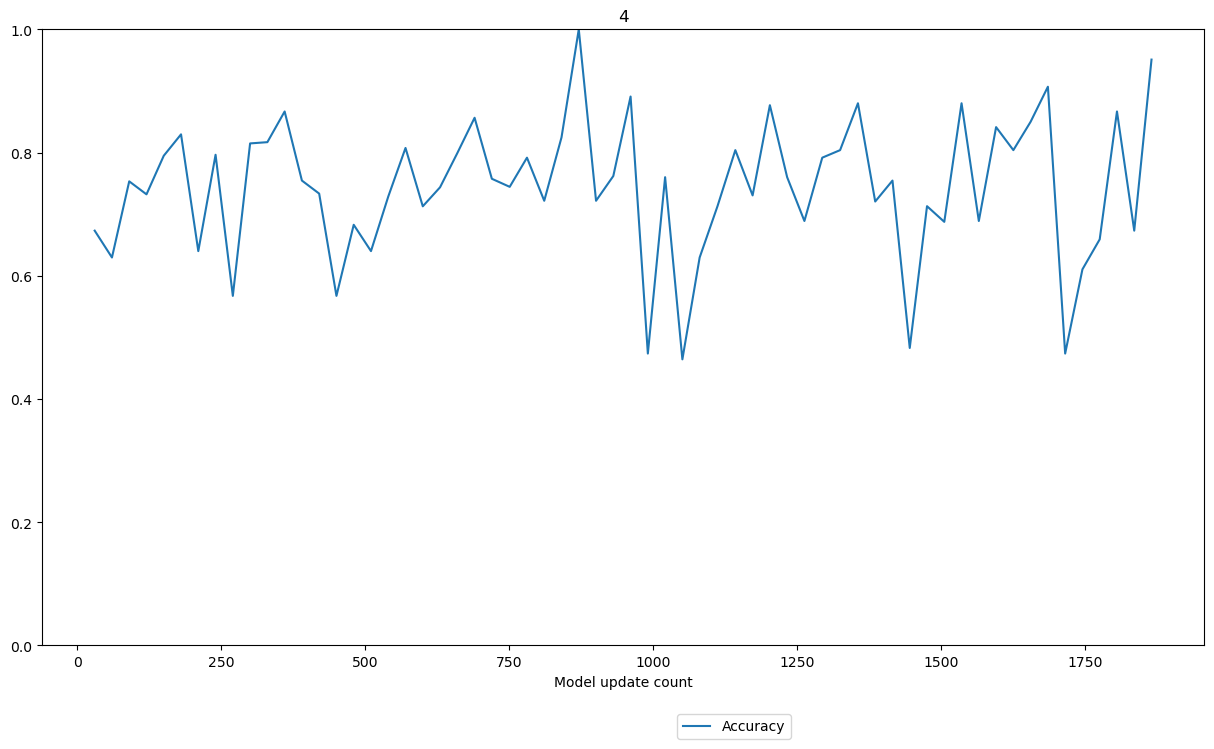

[{0: 0.42451853, 1: 0.5754815}, {0: 0.31549639, 1: 0.6845036}, {0: 0.5, 1: 0.5}, {0: 0.23758072, 1: 0.7624193}, {0: 0.23758072, 1: 0.7624193}, {0: 0.31549639, 1: 0.6845036}, {0: 0.42574054, 1: 0.57425946}, {0: 0.42451853, 1: 0.5754815}, {0: 0.23758072, 1: 0.7624193}, {0: 0.23758072, 1: 0.7624193}, {0: 0.23758072, 1: 0.7624193}, {0: 0.23758072, 1: 0.7624193}, {0: 0.23758072, 1: 0.7624193}, {0: 0.31549639, 1: 0.6845036}, {0: 0.23758072, 1: 0.7624193}, {0: 0.5, 1: 0.5}, {0: 0.23758072, 1: 0.7624193}, {0: 0.23758072, 1: 0.7624193}, {0: 0.23758072, 1: 0.7624193}, {0: 0.23758072, 1: 0.7624193}, {0: 0.23758072, 1: 0.7624193}, {0: 0.23758072, 1: 0.7624193}, {0: 0.42574054, 1: 0.57425946}, {0: 0.23758072, 1: 0.7624193}, {0: 0.42451853, 1: 0.5754815}, {0: 0.42451853, 1: 0.5754815}, {0: 0.31549639, 1: 0.6845036}, {0: 0.31549639, 1: 0.6845036}, {0: 0.5, 1: 0.5}, {0: 0.5, 1: 0.5}]
[{0: 0.37649924, 1: 0.62350076}, {0: 0.46802902, 1: 0.531971}, {0: 0.21314996, 1: 0.78685004}, {0: 0.31144732, 1: 0.688

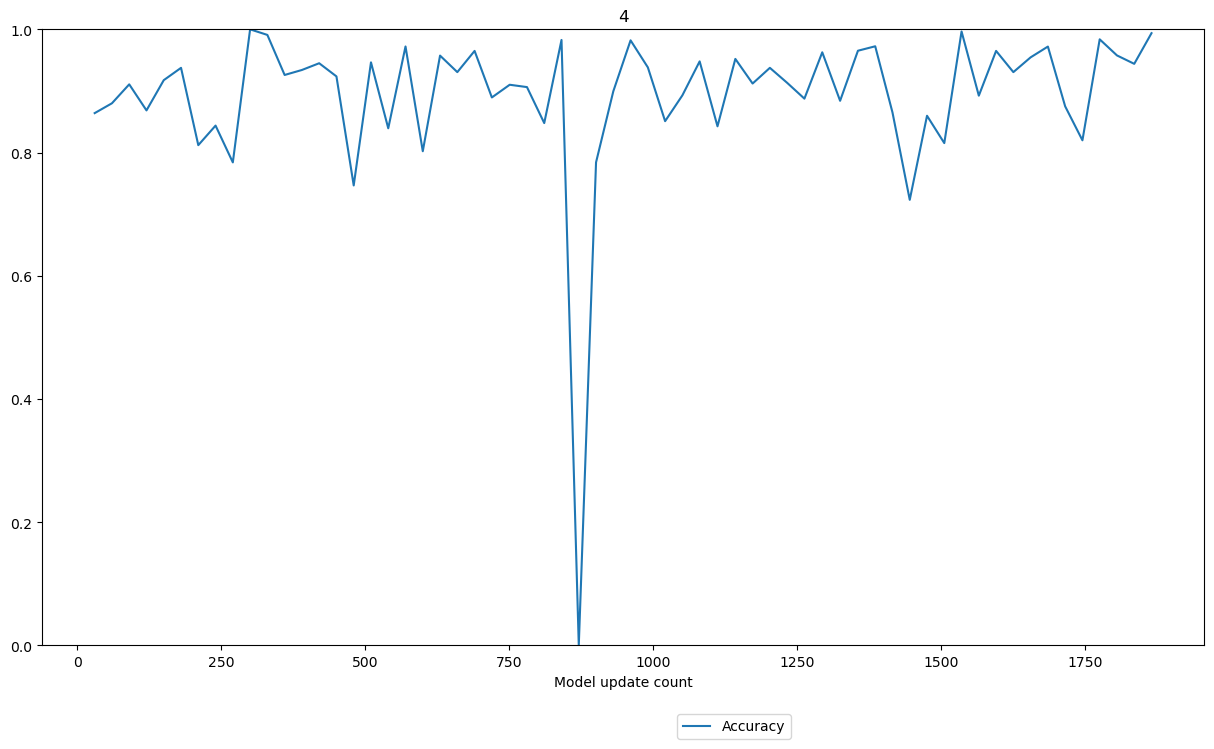

5
{1: {}, 2: {}, 3: {}, 4: {}, 5: {30: {'y_true': ['False', 'False', 'False', 'True', 'True', 'True', 'False', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'True'], 'y_pred': [array([[0.5407493 , 0.45925066]], dtype=float32), array([[0.30245954, 0.69754046]], dtype=float32), array([[0.514461  , 0.48553902]], dtype=float32), array([[0.26114094, 0.73885906]], dtype=float32), array([[0.24130338, 0.7586966 ]], dtype=float32), array([[0.30245954, 0.69754046]], dtype=float32), array([[0.5407493 , 0.45925066]], dtype=float32), array([[0.3623253, 0.6376747]], dtype=float32), array([[0.24130338, 0.7586966 ]], dtype=float32), array([[0.24130338, 0.7586966 ]], dtype=float32), array([[0.24130338, 0.7586966 ]], dtype=float32), array([[0.26114094, 0.73885906]], dtype=float32), array([[0.24130338, 0.7586966 ]], dtype=float32), array([[0.30245954, 0.69754046]], dtype=floa

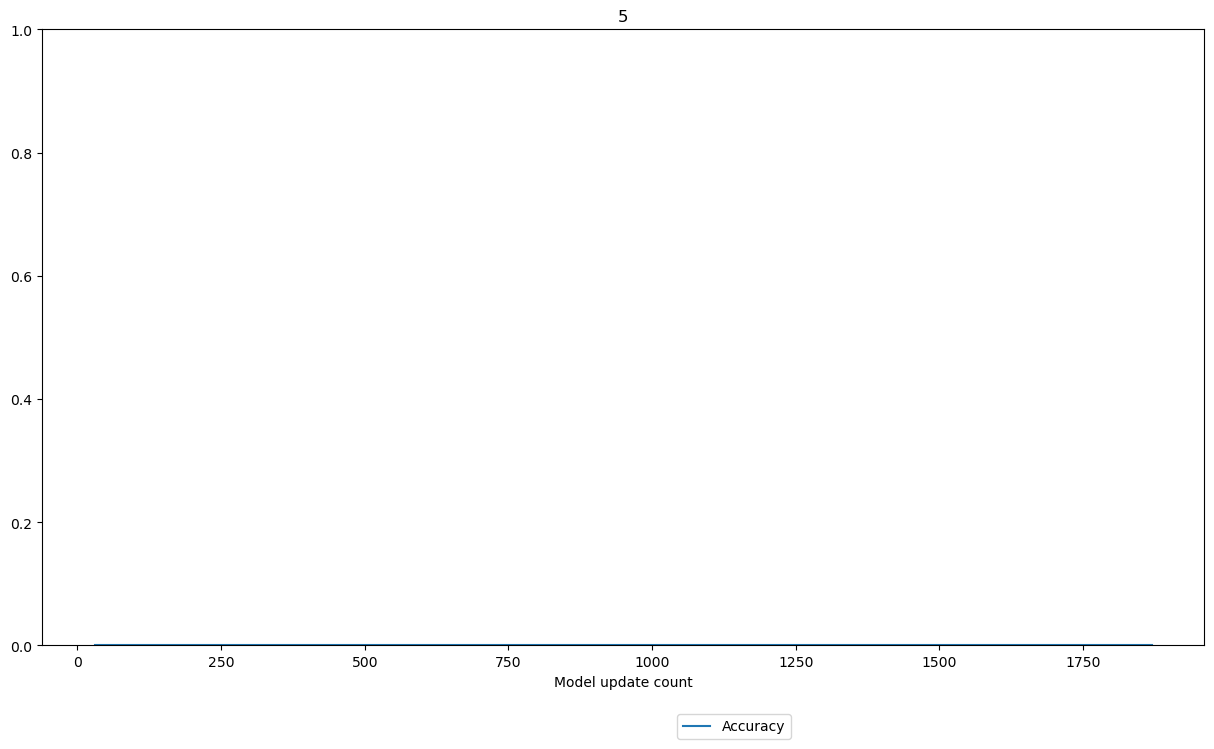

{1: {}, 2: {}, 3: {}, 4: {}, 5: {30: {'y_true': ['False', 'False', 'False', 'True', 'True', 'True', 'False', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'True'], 'y_pred': [array([[0.5407493 , 0.45925066]], dtype=float32), array([[0.30245954, 0.69754046]], dtype=float32), array([[0.514461  , 0.48553902]], dtype=float32), array([[0.26114094, 0.73885906]], dtype=float32), array([[0.24130338, 0.7586966 ]], dtype=float32), array([[0.30245954, 0.69754046]], dtype=float32), array([[0.5407493 , 0.45925066]], dtype=float32), array([[0.3623253, 0.6376747]], dtype=float32), array([[0.24130338, 0.7586966 ]], dtype=float32), array([[0.24130338, 0.7586966 ]], dtype=float32), array([[0.24130338, 0.7586966 ]], dtype=float32), array([[0.26114094, 0.73885906]], dtype=float32), array([[0.24130338, 0.7586966 ]], dtype=float32), array([[0.30245954, 0.69754046]], dtype=float3

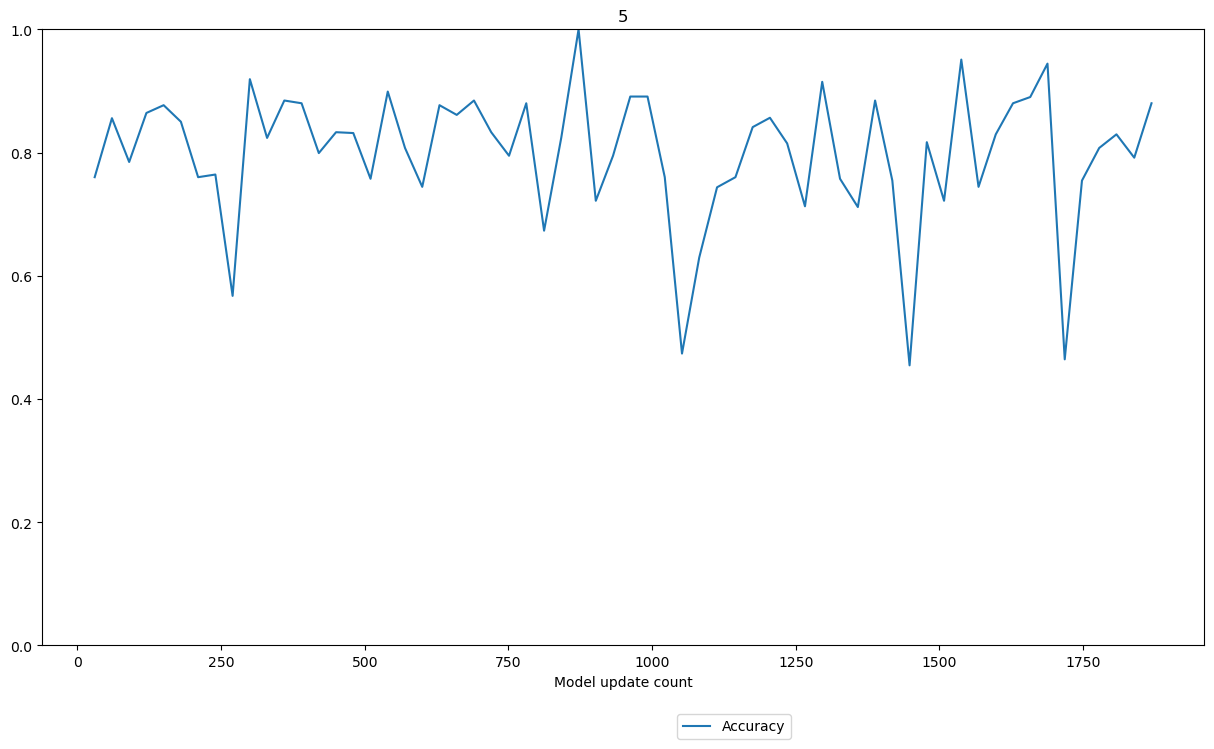

[{0: 0.5407493, 1: 0.45925066}, {0: 0.30245954, 1: 0.69754046}, {0: 0.514461, 1: 0.48553902}, {0: 0.26114094, 1: 0.73885906}, {0: 0.24130338, 1: 0.7586966}, {0: 0.30245954, 1: 0.69754046}, {0: 0.5407493, 1: 0.45925066}, {0: 0.3623253, 1: 0.6376747}, {0: 0.24130338, 1: 0.7586966}, {0: 0.24130338, 1: 0.7586966}, {0: 0.24130338, 1: 0.7586966}, {0: 0.26114094, 1: 0.73885906}, {0: 0.24130338, 1: 0.7586966}, {0: 0.30245954, 1: 0.69754046}, {0: 0.24130338, 1: 0.7586966}, {0: 0.514461, 1: 0.48553902}, {0: 0.26114094, 1: 0.73885906}, {0: 0.24130338, 1: 0.7586966}, {0: 0.24130338, 1: 0.7586966}, {0: 0.24130338, 1: 0.7586966}, {0: 0.24130338, 1: 0.7586966}, {0: 0.24130338, 1: 0.7586966}, {0: 0.3623253, 1: 0.6376747}, {0: 0.24130338, 1: 0.7586966}, {0: 0.3623253, 1: 0.6376747}, {0: 0.3623253, 1: 0.6376747}, {0: 0.30245954, 1: 0.69754046}, {0: 0.30245954, 1: 0.69754046}, {0: 0.3623253, 1: 0.6376747}, {0: 0.514461, 1: 0.48553902}]
[{0: 0.33497667, 1: 0.6650233}, {0: 0.5000911, 1: 0.49990895}, {0: 0.

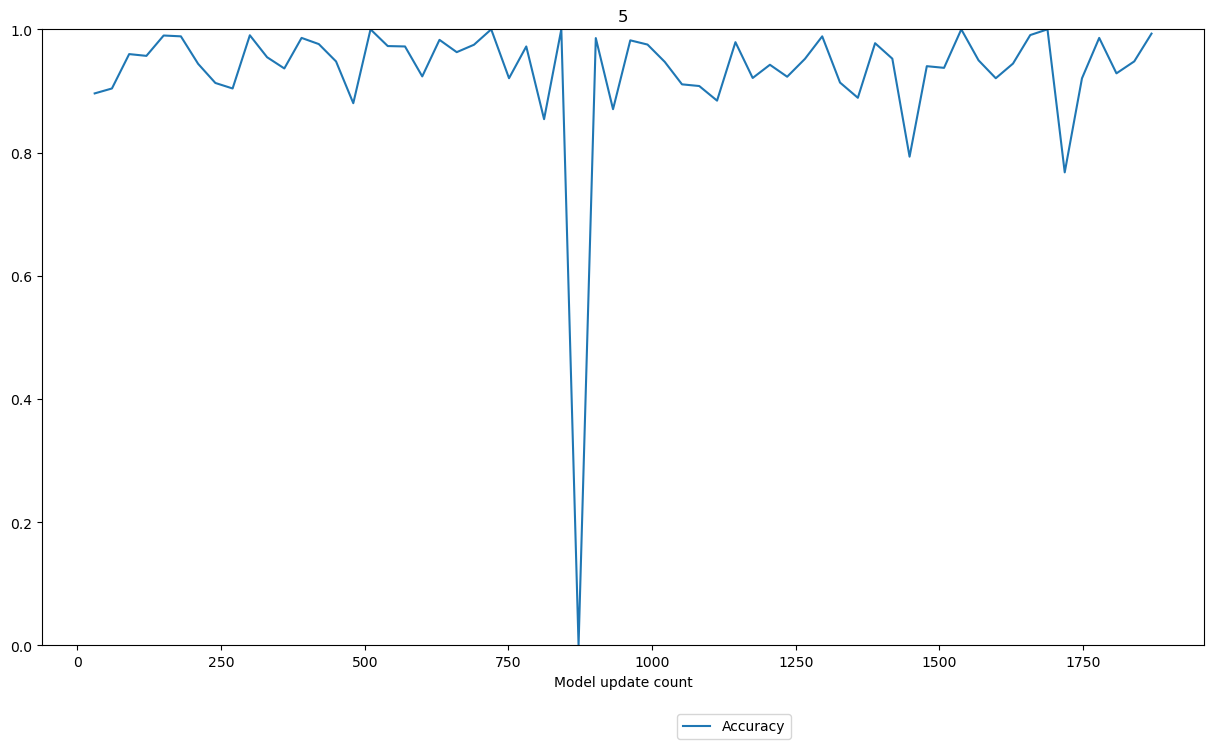

6
{1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {30: {'y_true': ['False', 'False', 'False', 'True', 'True', 'True', 'False', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'True'], 'y_pred': [array([[0.5407976 , 0.45920238]], dtype=float32), array([[0.31391758, 0.6860824 ]], dtype=float32), array([[0.5133108 , 0.48668918]], dtype=float32), array([[0.26044214, 0.73955786]], dtype=float32), array([[0.23976469, 0.7602353 ]], dtype=float32), array([[0.27544385, 0.72455615]], dtype=float32), array([[0.5407976 , 0.45920238]], dtype=float32), array([[0.36126906, 0.63873094]], dtype=float32), array([[0.23976469, 0.7602353 ]], dtype=float32), array([[0.27514726, 0.72485274]], dtype=float32), array([[0.23976469, 0.7602353 ]], dtype=float32), array([[0.26044214, 0.73955786]], dtype=float32), array([[0.27514726, 0.72485274]], dtype=float32), array([[0.31391758, 0.6860824 ]], d

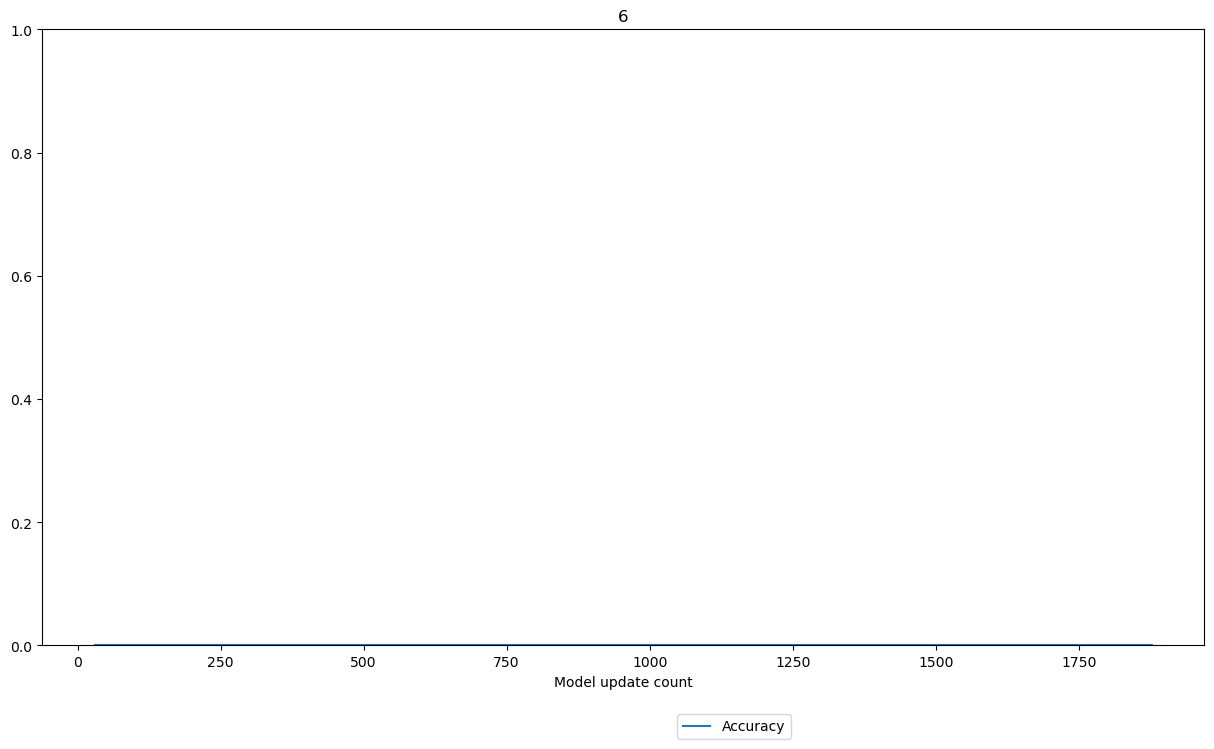

{1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {30: {'y_true': ['False', 'False', 'False', 'True', 'True', 'True', 'False', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'True'], 'y_pred': [array([[0.5407976 , 0.45920238]], dtype=float32), array([[0.31391758, 0.6860824 ]], dtype=float32), array([[0.5133108 , 0.48668918]], dtype=float32), array([[0.26044214, 0.73955786]], dtype=float32), array([[0.23976469, 0.7602353 ]], dtype=float32), array([[0.27544385, 0.72455615]], dtype=float32), array([[0.5407976 , 0.45920238]], dtype=float32), array([[0.36126906, 0.63873094]], dtype=float32), array([[0.23976469, 0.7602353 ]], dtype=float32), array([[0.27514726, 0.72485274]], dtype=float32), array([[0.23976469, 0.7602353 ]], dtype=float32), array([[0.26044214, 0.73955786]], dtype=float32), array([[0.27514726, 0.72485274]], dtype=float32), array([[0.31391758, 0.6860824 ]], dty

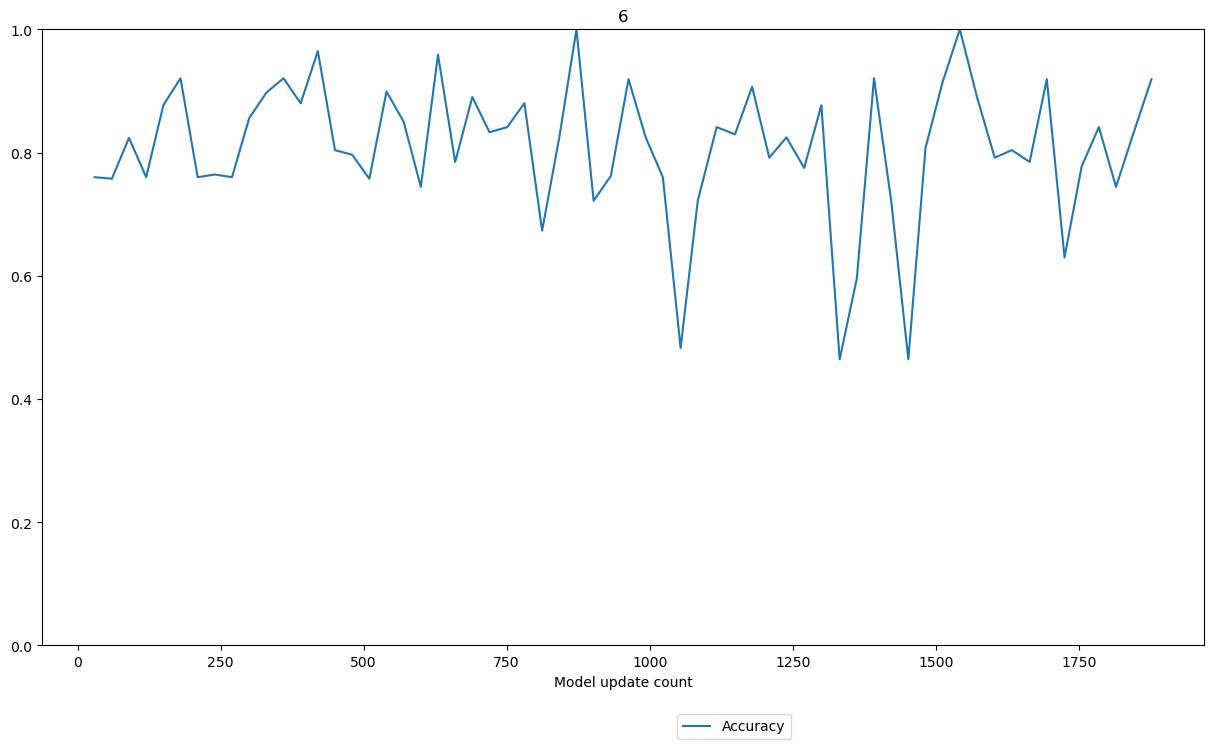

[{0: 0.5407976, 1: 0.45920238}, {0: 0.31391758, 1: 0.6860824}, {0: 0.5133108, 1: 0.48668918}, {0: 0.26044214, 1: 0.73955786}, {0: 0.23976469, 1: 0.7602353}, {0: 0.27544385, 1: 0.72455615}, {0: 0.5407976, 1: 0.45920238}, {0: 0.36126906, 1: 0.63873094}, {0: 0.23976469, 1: 0.7602353}, {0: 0.27514726, 1: 0.72485274}, {0: 0.23976469, 1: 0.7602353}, {0: 0.26044214, 1: 0.73955786}, {0: 0.27514726, 1: 0.72485274}, {0: 0.31391758, 1: 0.6860824}, {0: 0.23976469, 1: 0.7602353}, {0: 0.5133108, 1: 0.48668918}, {0: 0.26044214, 1: 0.73955786}, {0: 0.23976469, 1: 0.7602353}, {0: 0.23976469, 1: 0.7602353}, {0: 0.23976469, 1: 0.7602353}, {0: 0.23976469, 1: 0.7602353}, {0: 0.27514726, 1: 0.72485274}, {0: 0.36126906, 1: 0.63873094}, {0: 0.23976469, 1: 0.7602353}, {0: 0.36126906, 1: 0.63873094}, {0: 0.36126906, 1: 0.63873094}, {0: 0.27544385, 1: 0.72455615}, {0: 0.27544385, 1: 0.72455615}, {0: 0.36126906, 1: 0.63873094}, {0: 0.5133108, 1: 0.48668918}]
[{0: 0.30514908, 1: 0.6948509}, {0: 0.45803142, 1: 0.54

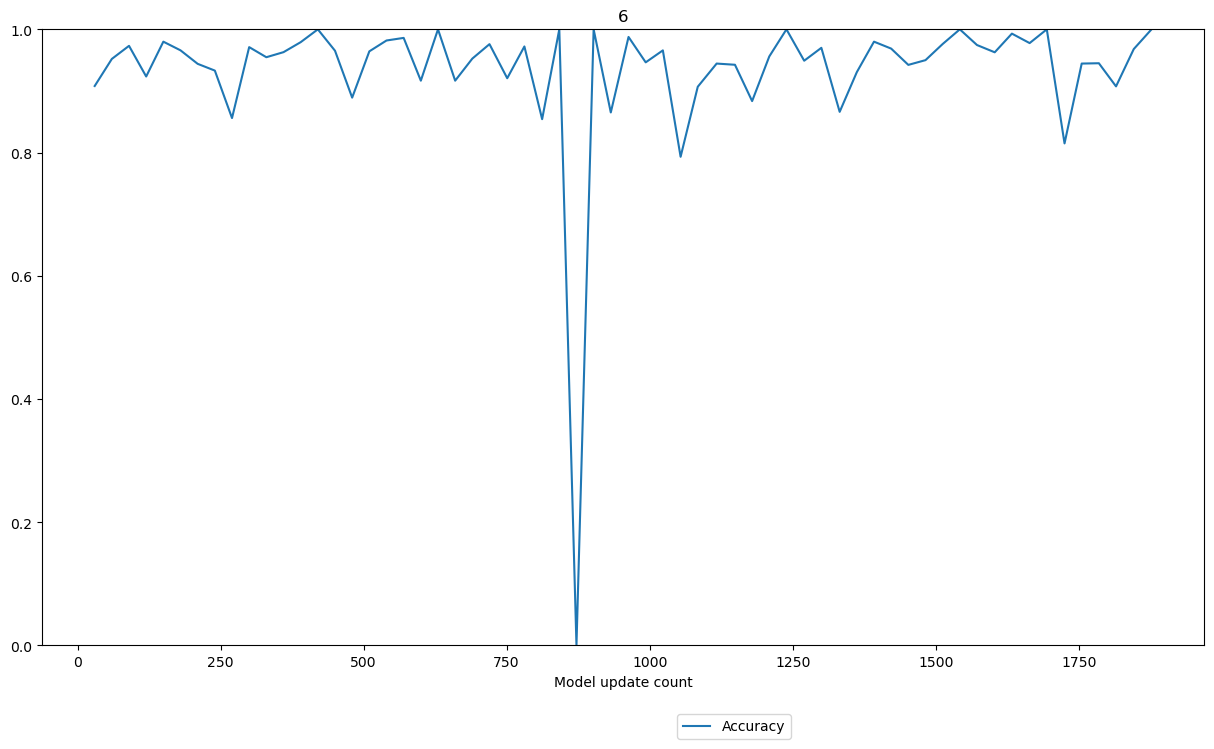

7
{1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {30: {'y_true': ['False', 'False', 'False', 'True', 'True', 'True', 'False', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'True'], 'y_pred': [array([[0.5482577 , 0.45174226]], dtype=float32), array([[0.31631404, 0.68368596]], dtype=float32), array([[0.5482577 , 0.45174226]], dtype=float32), array([[0.2666331, 0.7333669]], dtype=float32), array([[0.2577327, 0.7422673]], dtype=float32), array([[0.27459514, 0.72540486]], dtype=float32), array([[0.5482577 , 0.45174226]], dtype=float32), array([[0.36222923, 0.6377708 ]], dtype=float32), array([[0.23627079, 0.7637292 ]], dtype=float32), array([[0.27436936, 0.72563064]], dtype=float32), array([[0.23627079, 0.7637292 ]], dtype=float32), array([[0.23627079, 0.7637292 ]], dtype=float32), array([[0.27436936, 0.72563064]], dtype=float32), array([[0.31631404, 0.68368596]]

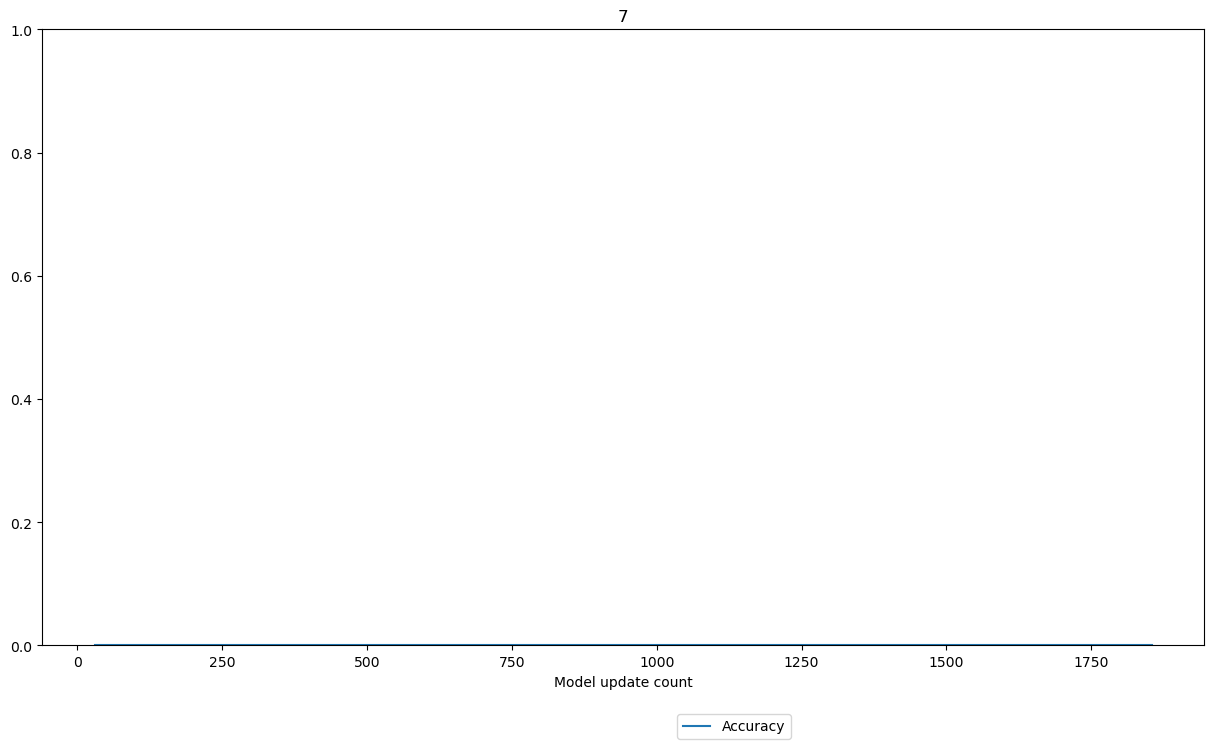

{1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {30: {'y_true': ['False', 'False', 'False', 'True', 'True', 'True', 'False', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'True'], 'y_pred': [array([[0.5482577 , 0.45174226]], dtype=float32), array([[0.31631404, 0.68368596]], dtype=float32), array([[0.5482577 , 0.45174226]], dtype=float32), array([[0.2666331, 0.7333669]], dtype=float32), array([[0.2577327, 0.7422673]], dtype=float32), array([[0.27459514, 0.72540486]], dtype=float32), array([[0.5482577 , 0.45174226]], dtype=float32), array([[0.36222923, 0.6377708 ]], dtype=float32), array([[0.23627079, 0.7637292 ]], dtype=float32), array([[0.27436936, 0.72563064]], dtype=float32), array([[0.23627079, 0.7637292 ]], dtype=float32), array([[0.23627079, 0.7637292 ]], dtype=float32), array([[0.27436936, 0.72563064]], dtype=float32), array([[0.31631404, 0.68368596]], 

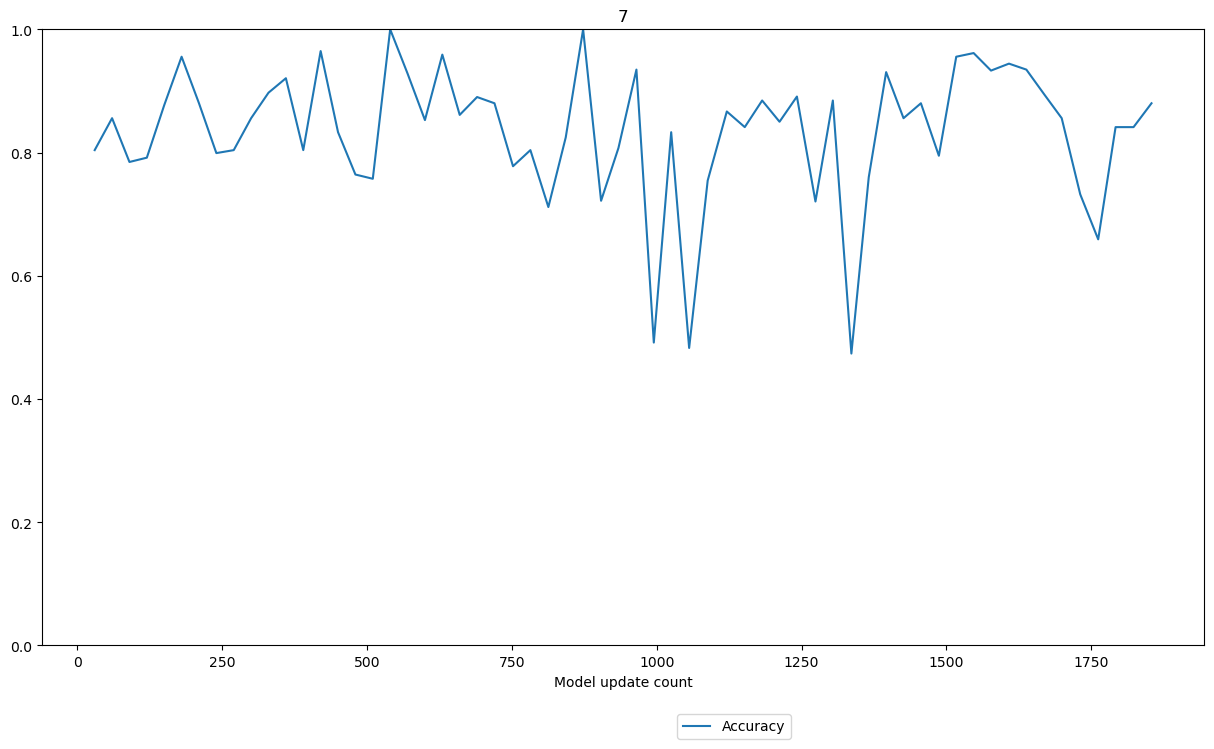

[{0: 0.5482577, 1: 0.45174226}, {0: 0.31631404, 1: 0.68368596}, {0: 0.5482577, 1: 0.45174226}, {0: 0.2666331, 1: 0.7333669}, {0: 0.2577327, 1: 0.7422673}, {0: 0.27459514, 1: 0.72540486}, {0: 0.5482577, 1: 0.45174226}, {0: 0.36222923, 1: 0.6377708}, {0: 0.23627079, 1: 0.7637292}, {0: 0.27436936, 1: 0.72563064}, {0: 0.23627079, 1: 0.7637292}, {0: 0.23627079, 1: 0.7637292}, {0: 0.27436936, 1: 0.72563064}, {0: 0.31631404, 1: 0.68368596}, {0: 0.23627079, 1: 0.7637292}, {0: 0.5482577, 1: 0.45174226}, {0: 0.29659986, 1: 0.70340014}, {0: 0.23627079, 1: 0.7637292}, {0: 0.23627079, 1: 0.7637292}, {0: 0.23627079, 1: 0.7637292}, {0: 0.23627079, 1: 0.7637292}, {0: 0.27436936, 1: 0.72563064}, {0: 0.36222923, 1: 0.6377708}, {0: 0.23627079, 1: 0.7637292}, {0: 0.42167723, 1: 0.57832277}, {0: 0.3360046, 1: 0.6639954}, {0: 0.27459514, 1: 0.72540486}, {0: 0.27459514, 1: 0.72540486}, {0: 0.36546975, 1: 0.63453025}, {0: 0.42071104, 1: 0.57928896}]
[{0: 0.42874247, 1: 0.57125753}, {0: 0.55184627, 1: 0.448153

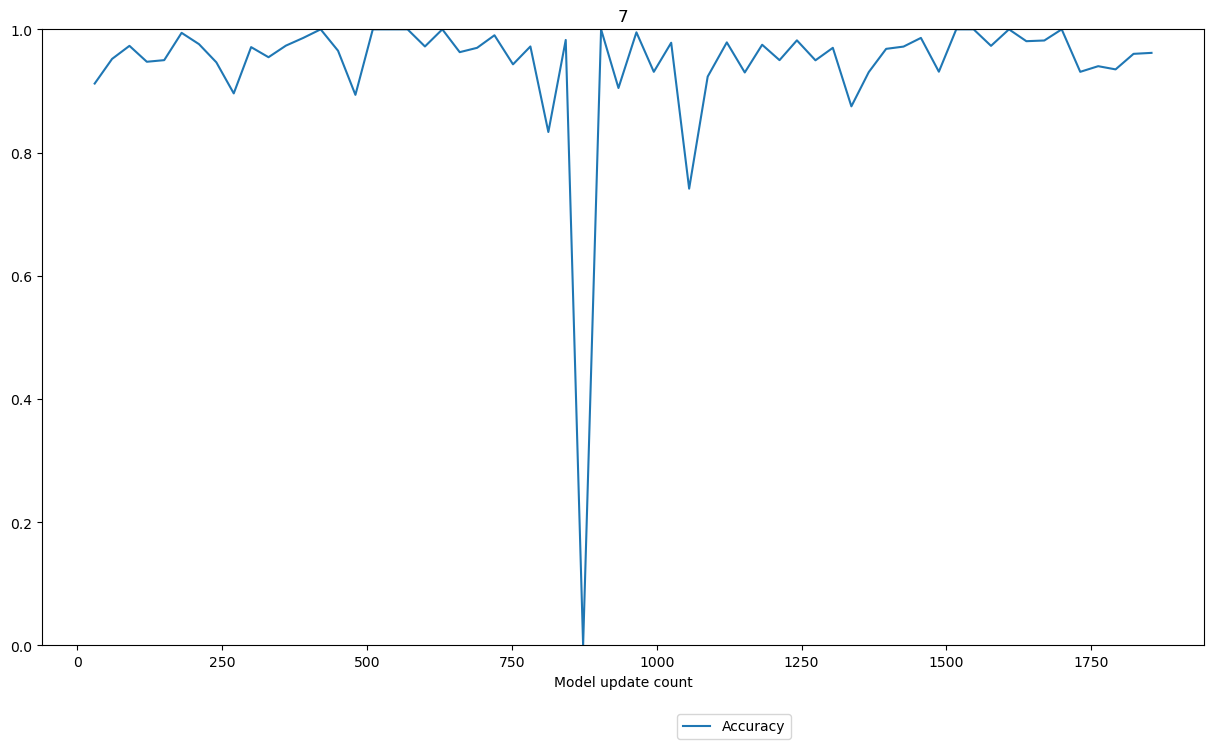

8
{1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {30: {'y_true': ['False', 'False', 'False', 'True', 'True', 'True', 'False', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'True'], 'y_pred': [array([[0.5482577 , 0.45174226]], dtype=float32), array([[0.31631404, 0.68368596]], dtype=float32), array([[0.5482577 , 0.45174226]], dtype=float32), array([[0.2666331, 0.7333669]], dtype=float32), array([[0.2577327, 0.7422673]], dtype=float32), array([[0.27459514, 0.72540486]], dtype=float32), array([[0.5482577 , 0.45174226]], dtype=float32), array([[0.36222923, 0.6377708 ]], dtype=float32), array([[0.23627079, 0.7637292 ]], dtype=float32), array([[0.27436936, 0.72563064]], dtype=float32), array([[0.23627079, 0.7637292 ]], dtype=float32), array([[0.23627079, 0.7637292 ]], dtype=float32), array([[0.27436936, 0.72563064]], dtype=float32), array([[0.31631404, 0.683

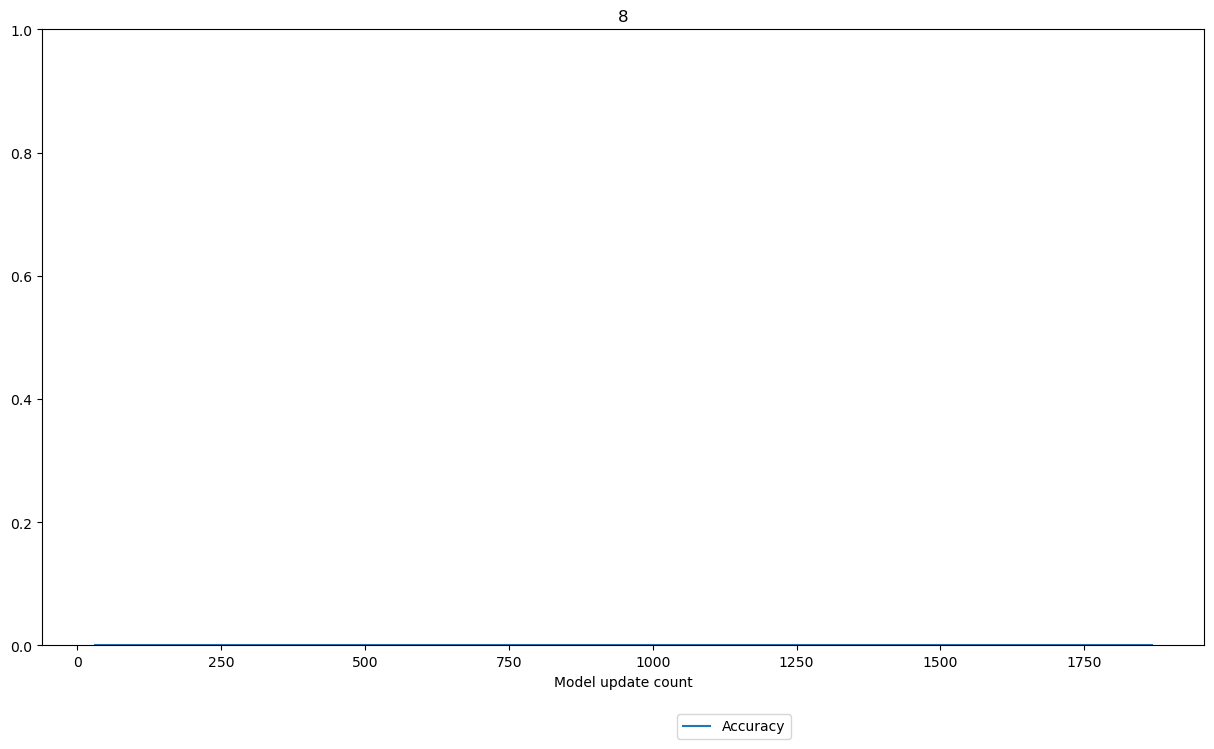

{1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {30: {'y_true': ['False', 'False', 'False', 'True', 'True', 'True', 'False', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'True'], 'y_pred': [array([[0.5482577 , 0.45174226]], dtype=float32), array([[0.31631404, 0.68368596]], dtype=float32), array([[0.5482577 , 0.45174226]], dtype=float32), array([[0.2666331, 0.7333669]], dtype=float32), array([[0.2577327, 0.7422673]], dtype=float32), array([[0.27459514, 0.72540486]], dtype=float32), array([[0.5482577 , 0.45174226]], dtype=float32), array([[0.36222923, 0.6377708 ]], dtype=float32), array([[0.23627079, 0.7637292 ]], dtype=float32), array([[0.27436936, 0.72563064]], dtype=float32), array([[0.23627079, 0.7637292 ]], dtype=float32), array([[0.23627079, 0.7637292 ]], dtype=float32), array([[0.27436936, 0.72563064]], dtype=float32), array([[0.31631404, 0.68368

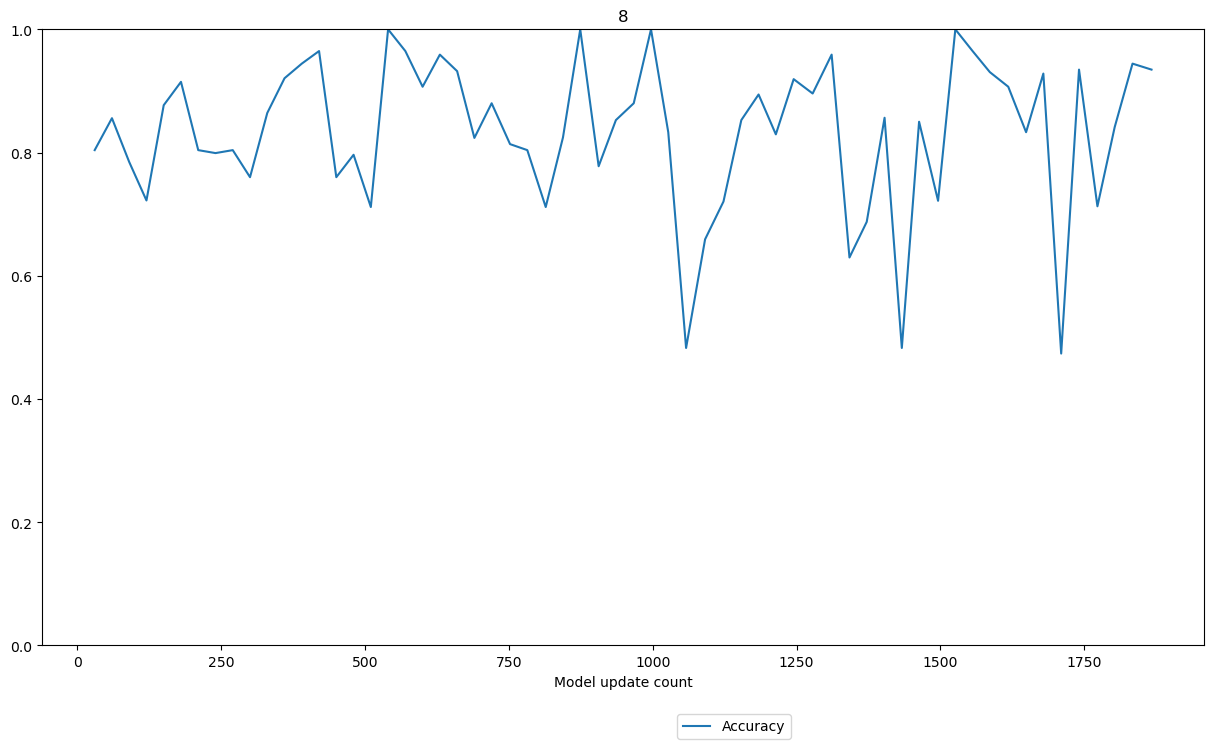

[{0: 0.5482577, 1: 0.45174226}, {0: 0.31631404, 1: 0.68368596}, {0: 0.5482577, 1: 0.45174226}, {0: 0.2666331, 1: 0.7333669}, {0: 0.2577327, 1: 0.7422673}, {0: 0.27459514, 1: 0.72540486}, {0: 0.5482577, 1: 0.45174226}, {0: 0.36222923, 1: 0.6377708}, {0: 0.23627079, 1: 0.7637292}, {0: 0.27436936, 1: 0.72563064}, {0: 0.23627079, 1: 0.7637292}, {0: 0.23627079, 1: 0.7637292}, {0: 0.27436936, 1: 0.72563064}, {0: 0.31631404, 1: 0.68368596}, {0: 0.23627079, 1: 0.7637292}, {0: 0.5482577, 1: 0.45174226}, {0: 0.29659986, 1: 0.70340014}, {0: 0.23627079, 1: 0.7637292}, {0: 0.23627079, 1: 0.7637292}, {0: 0.23627079, 1: 0.7637292}, {0: 0.23627079, 1: 0.7637292}, {0: 0.27436936, 1: 0.72563064}, {0: 0.36222923, 1: 0.6377708}, {0: 0.23627079, 1: 0.7637292}, {0: 0.42167723, 1: 0.57832277}, {0: 0.3360046, 1: 0.6639954}, {0: 0.27459514, 1: 0.72540486}, {0: 0.27459514, 1: 0.72540486}, {0: 0.36546975, 1: 0.63453025}, {0: 0.42071104, 1: 0.57928896}]
[{0: 0.42874247, 1: 0.57125753}, {0: 0.55184627, 1: 0.448153

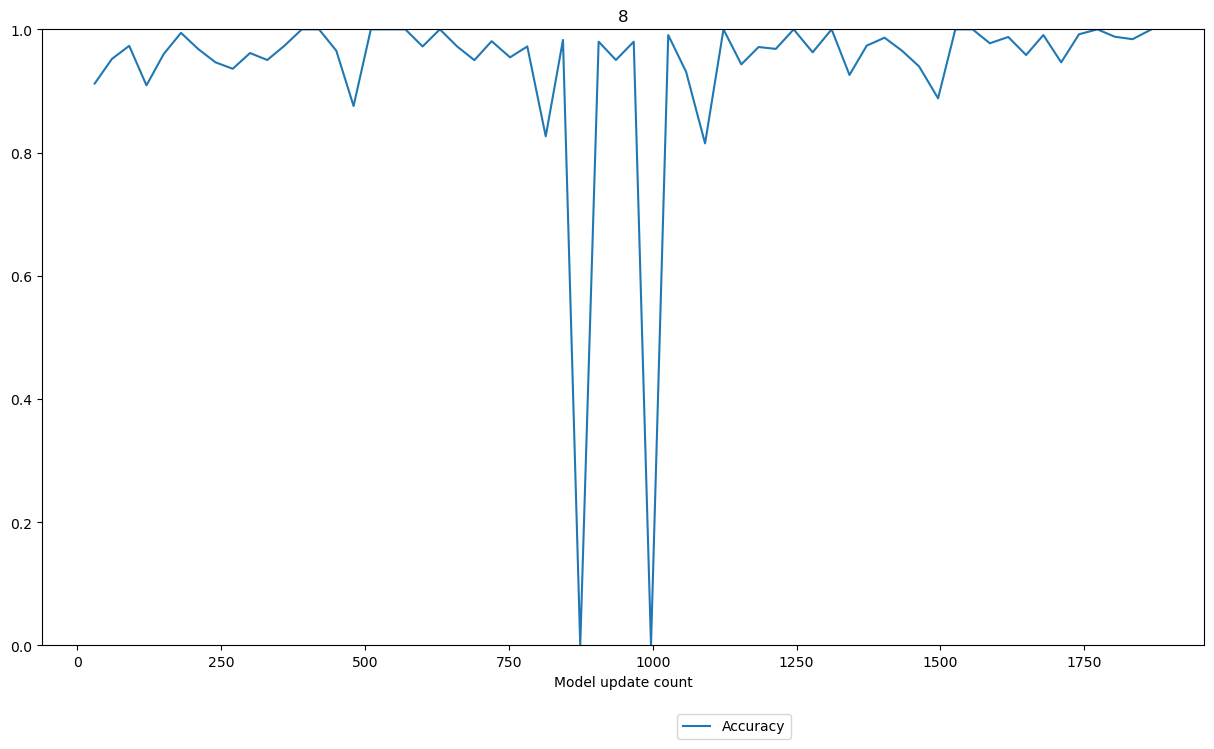

9
{1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {30: {'y_true': ['False', 'False', 'False', 'True', 'True', 'True', 'False', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'True'], 'y_pred': [array([[0.5482577 , 0.45174226]], dtype=float32), array([[0.31631404, 0.68368596]], dtype=float32), array([[0.5482577 , 0.45174226]], dtype=float32), array([[0.2666331, 0.7333669]], dtype=float32), array([[0.2577327, 0.7422673]], dtype=float32), array([[0.27459514, 0.72540486]], dtype=float32), array([[0.5482577 , 0.45174226]], dtype=float32), array([[0.36222923, 0.6377708 ]], dtype=float32), array([[0.23627079, 0.7637292 ]], dtype=float32), array([[0.27436936, 0.72563064]], dtype=float32), array([[0.23627079, 0.7637292 ]], dtype=float32), array([[0.23627079, 0.7637292 ]], dtype=float32), array([[0.27436936, 0.72563064]], dtype=float32), array([[0.31631404

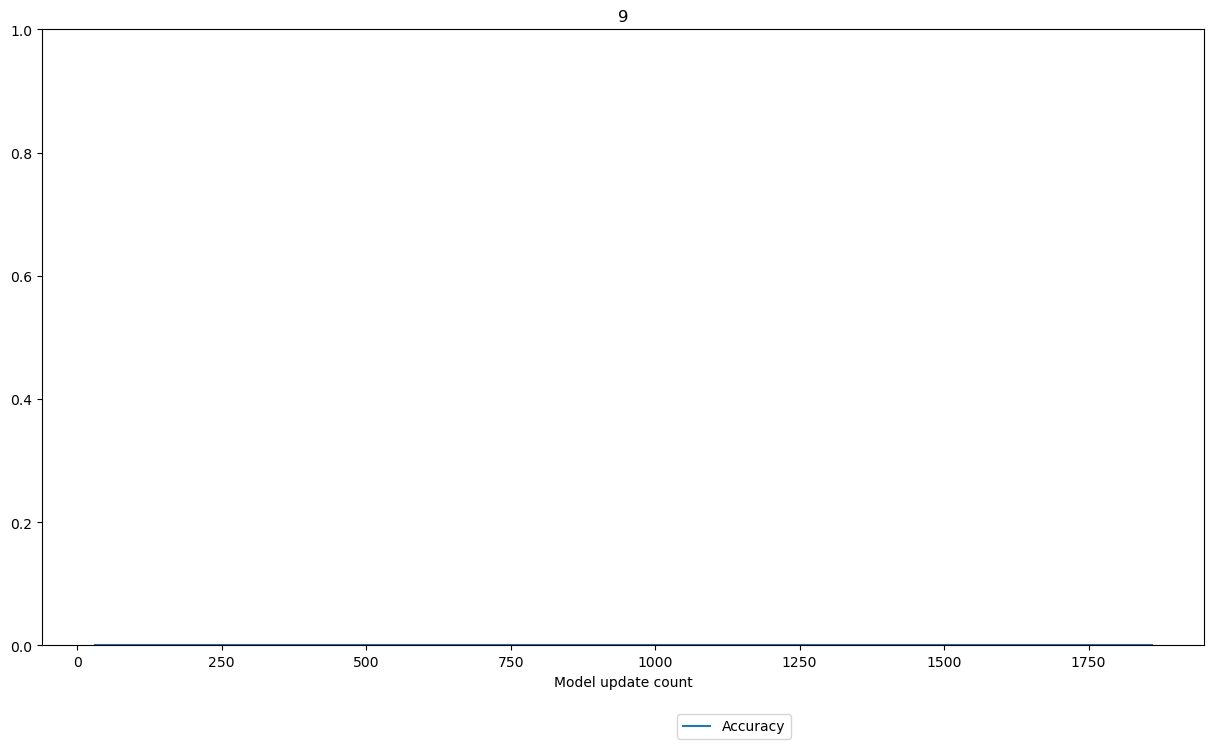

{1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {30: {'y_true': ['False', 'False', 'False', 'True', 'True', 'True', 'False', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'True'], 'y_pred': [array([[0.5482577 , 0.45174226]], dtype=float32), array([[0.31631404, 0.68368596]], dtype=float32), array([[0.5482577 , 0.45174226]], dtype=float32), array([[0.2666331, 0.7333669]], dtype=float32), array([[0.2577327, 0.7422673]], dtype=float32), array([[0.27459514, 0.72540486]], dtype=float32), array([[0.5482577 , 0.45174226]], dtype=float32), array([[0.36222923, 0.6377708 ]], dtype=float32), array([[0.23627079, 0.7637292 ]], dtype=float32), array([[0.27436936, 0.72563064]], dtype=float32), array([[0.23627079, 0.7637292 ]], dtype=float32), array([[0.23627079, 0.7637292 ]], dtype=float32), array([[0.27436936, 0.72563064]], dtype=float32), array([[0.31631404, 

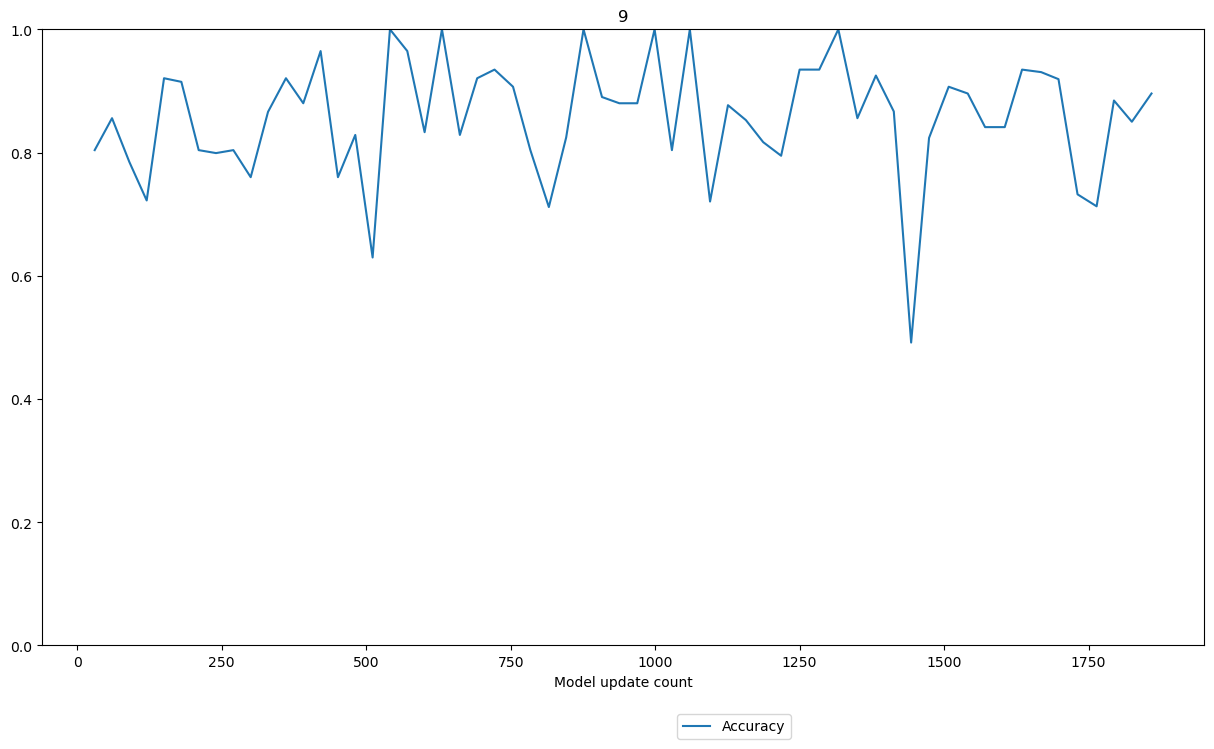

[{0: 0.5482577, 1: 0.45174226}, {0: 0.31631404, 1: 0.68368596}, {0: 0.5482577, 1: 0.45174226}, {0: 0.2666331, 1: 0.7333669}, {0: 0.2577327, 1: 0.7422673}, {0: 0.27459514, 1: 0.72540486}, {0: 0.5482577, 1: 0.45174226}, {0: 0.36222923, 1: 0.6377708}, {0: 0.23627079, 1: 0.7637292}, {0: 0.27436936, 1: 0.72563064}, {0: 0.23627079, 1: 0.7637292}, {0: 0.23627079, 1: 0.7637292}, {0: 0.27436936, 1: 0.72563064}, {0: 0.31631404, 1: 0.68368596}, {0: 0.23627079, 1: 0.7637292}, {0: 0.5482577, 1: 0.45174226}, {0: 0.29659986, 1: 0.70340014}, {0: 0.23627079, 1: 0.7637292}, {0: 0.23627079, 1: 0.7637292}, {0: 0.23627079, 1: 0.7637292}, {0: 0.23627079, 1: 0.7637292}, {0: 0.27436936, 1: 0.72563064}, {0: 0.36222923, 1: 0.6377708}, {0: 0.23627079, 1: 0.7637292}, {0: 0.42167723, 1: 0.57832277}, {0: 0.3360046, 1: 0.6639954}, {0: 0.27459514, 1: 0.72540486}, {0: 0.27459514, 1: 0.72540486}, {0: 0.36546975, 1: 0.63453025}, {0: 0.42071104, 1: 0.57928896}]
[{0: 0.42874247, 1: 0.57125753}, {0: 0.55184627, 1: 0.448153

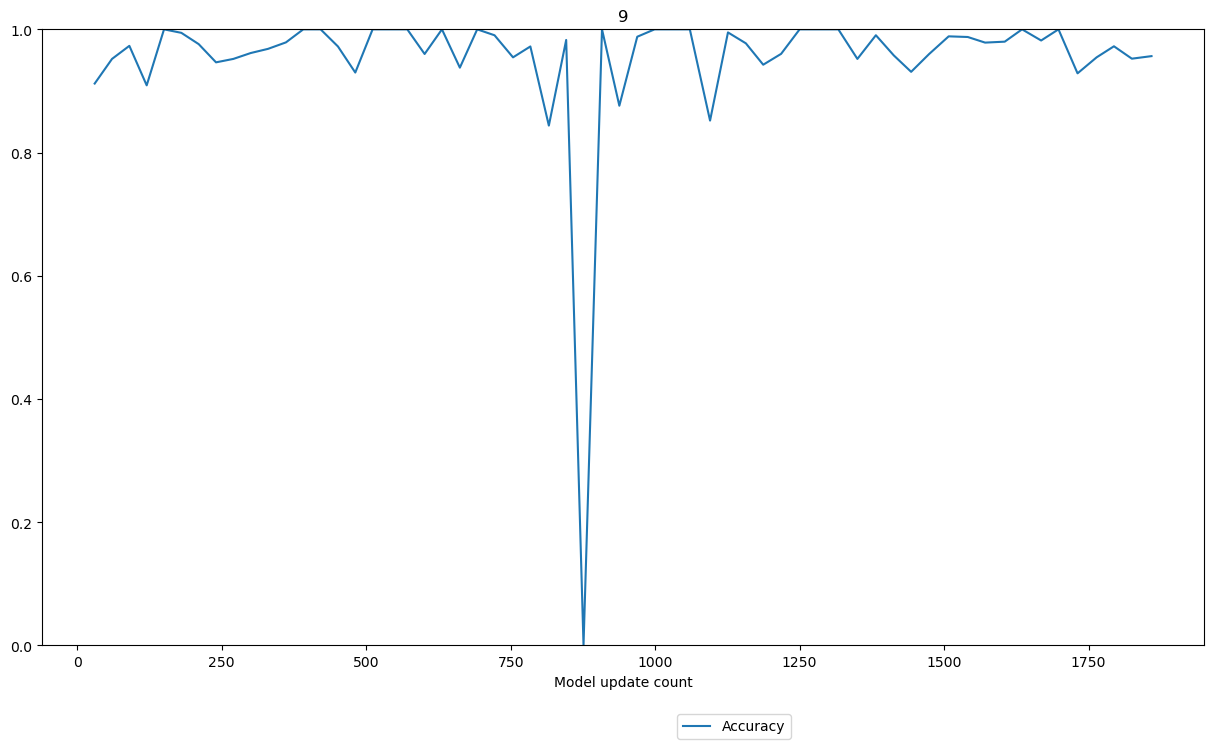

10
{1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {30: {'y_true': ['False', 'False', 'False', 'True', 'True', 'True', 'False', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'True'], 'y_pred': [array([[0.59360677, 0.40639323]], dtype=float32), array([[0.3711692, 0.6288308]], dtype=float32), array([[0.59360677, 0.40639323]], dtype=float32), array([[0.2297911, 0.7702089]], dtype=float32), array([[0.2297911, 0.7702089]], dtype=float32), array([[0.3567946, 0.6432054]], dtype=float32), array([[0.59360677, 0.40639323]], dtype=float32), array([[0.29686856, 0.70313144]], dtype=float32), array([[0.2297911, 0.7702089]], dtype=float32), array([[0.2657792, 0.7342208]], dtype=float32), array([[0.2297911, 0.7702089]], dtype=float32), array([[0.2297911, 0.7702089]], dtype=float32), array([[0.35679317, 0.64320683]], dtype=float32), array([[0.27807343, 0

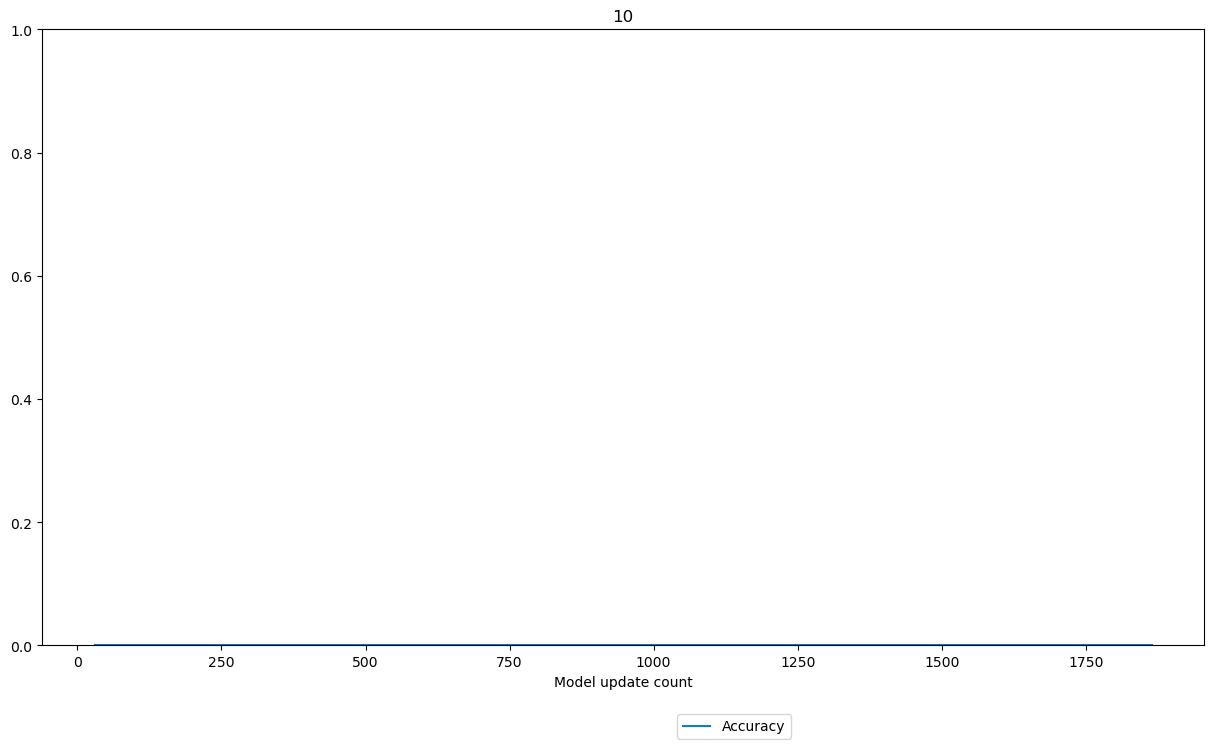

{1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {30: {'y_true': ['False', 'False', 'False', 'True', 'True', 'True', 'False', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'True'], 'y_pred': [array([[0.59360677, 0.40639323]], dtype=float32), array([[0.3711692, 0.6288308]], dtype=float32), array([[0.59360677, 0.40639323]], dtype=float32), array([[0.2297911, 0.7702089]], dtype=float32), array([[0.2297911, 0.7702089]], dtype=float32), array([[0.3567946, 0.6432054]], dtype=float32), array([[0.59360677, 0.40639323]], dtype=float32), array([[0.29686856, 0.70313144]], dtype=float32), array([[0.2297911, 0.7702089]], dtype=float32), array([[0.2657792, 0.7342208]], dtype=float32), array([[0.2297911, 0.7702089]], dtype=float32), array([[0.2297911, 0.7702089]], dtype=float32), array([[0.35679317, 0.64320683]], dtype=float32), array([[0.27807343, 0.72

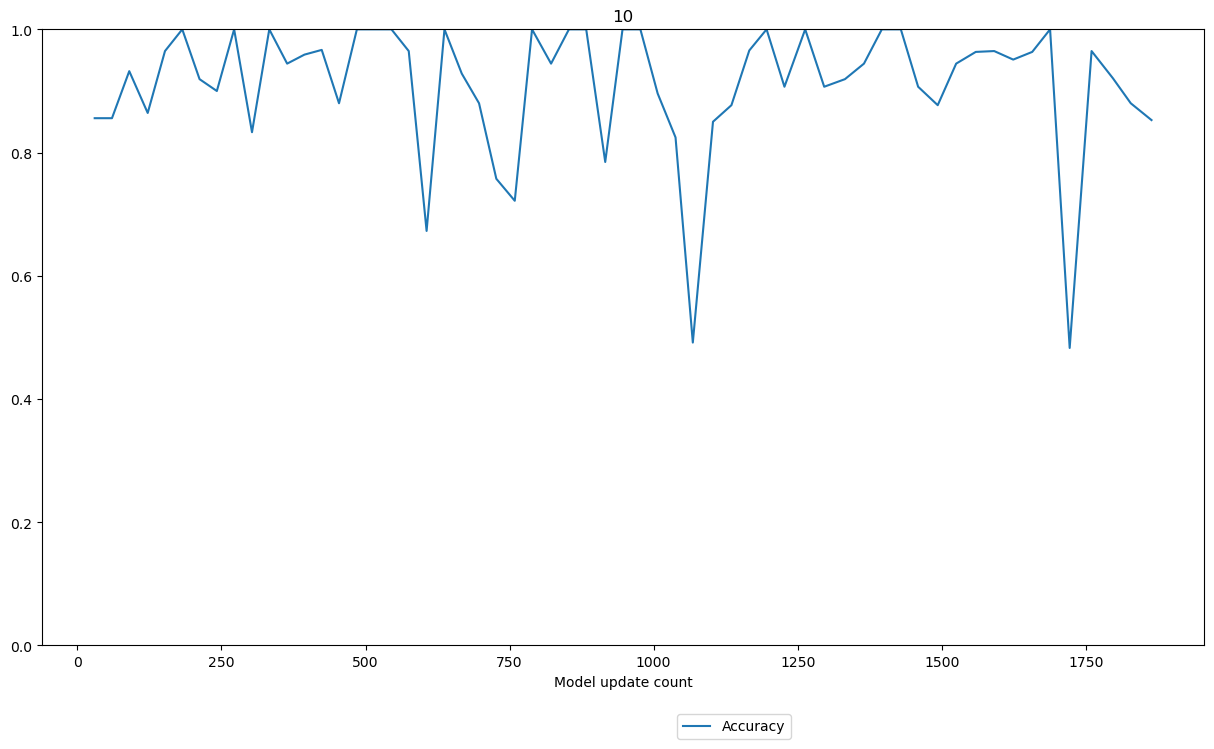

[{0: 0.59360677, 1: 0.40639323}, {0: 0.3711692, 1: 0.6288308}, {0: 0.59360677, 1: 0.40639323}, {0: 0.2297911, 1: 0.7702089}, {0: 0.2297911, 1: 0.7702089}, {0: 0.3567946, 1: 0.6432054}, {0: 0.59360677, 1: 0.40639323}, {0: 0.29686856, 1: 0.70313144}, {0: 0.2297911, 1: 0.7702089}, {0: 0.2657792, 1: 0.7342208}, {0: 0.2297911, 1: 0.7702089}, {0: 0.2297911, 1: 0.7702089}, {0: 0.35679317, 1: 0.64320683}, {0: 0.27807343, 1: 0.72192657}, {0: 0.25383842, 1: 0.7461616}, {0: 0.34563828, 1: 0.6543617}, {0: 0.40416282, 1: 0.5958372}, {0: 0.2297911, 1: 0.7702089}, {0: 0.2297911, 1: 0.7702089}, {0: 0.2297911, 1: 0.7702089}, {0: 0.25383842, 1: 0.7461616}, {0: 0.2657792, 1: 0.7342208}, {0: 0.33349234, 1: 0.66650766}, {0: 0.25383842, 1: 0.7461616}, {0: 0.32144314, 1: 0.67855686}, {0: 0.33349234, 1: 0.66650766}, {0: 0.26578033, 1: 0.7342197}, {0: 0.26578033, 1: 0.7342197}, {0: 0.49627173, 1: 0.5037283}, {0: 0.32008642, 1: 0.6799136}]
[{0: 0.20182806, 1: 0.79817194}, {0: 0.7301098, 1: 0.2698902}, {0: 0.201

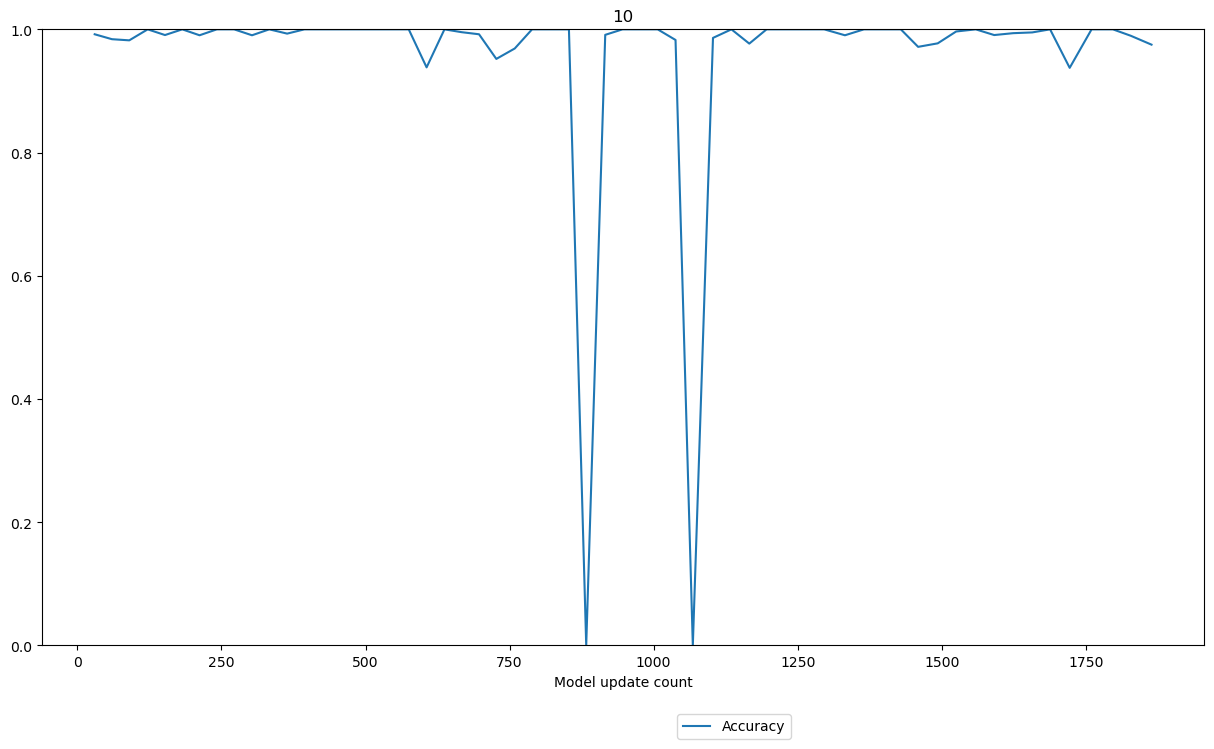

11
{1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {30: {'y_true': ['False', 'False', 'False', 'True', 'True', 'True', 'False', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'True'], 'y_pred': [array([[0.62799394, 0.3720061 ]], dtype=float32), array([[0.3341977, 0.6658023]], dtype=float32), array([[0.62799394, 0.3720061 ]], dtype=float32), array([[0.26199973, 0.7380003 ]], dtype=float32), array([[0.26199973, 0.7380003 ]], dtype=float32), array([[0.25687307, 0.7431269 ]], dtype=float32), array([[0.62799394, 0.3720061 ]], dtype=float32), array([[0.22377789, 0.7762221 ]], dtype=float32), array([[0.22377789, 0.7762221 ]], dtype=float32), array([[0.25370592, 0.7462941 ]], dtype=float32), array([[0.22377789, 0.7762221 ]], dtype=float32), array([[0.26199973, 0.7380003 ]], dtype=float32), array([[0.25370592, 0.7462941 ]], dtype=float32),

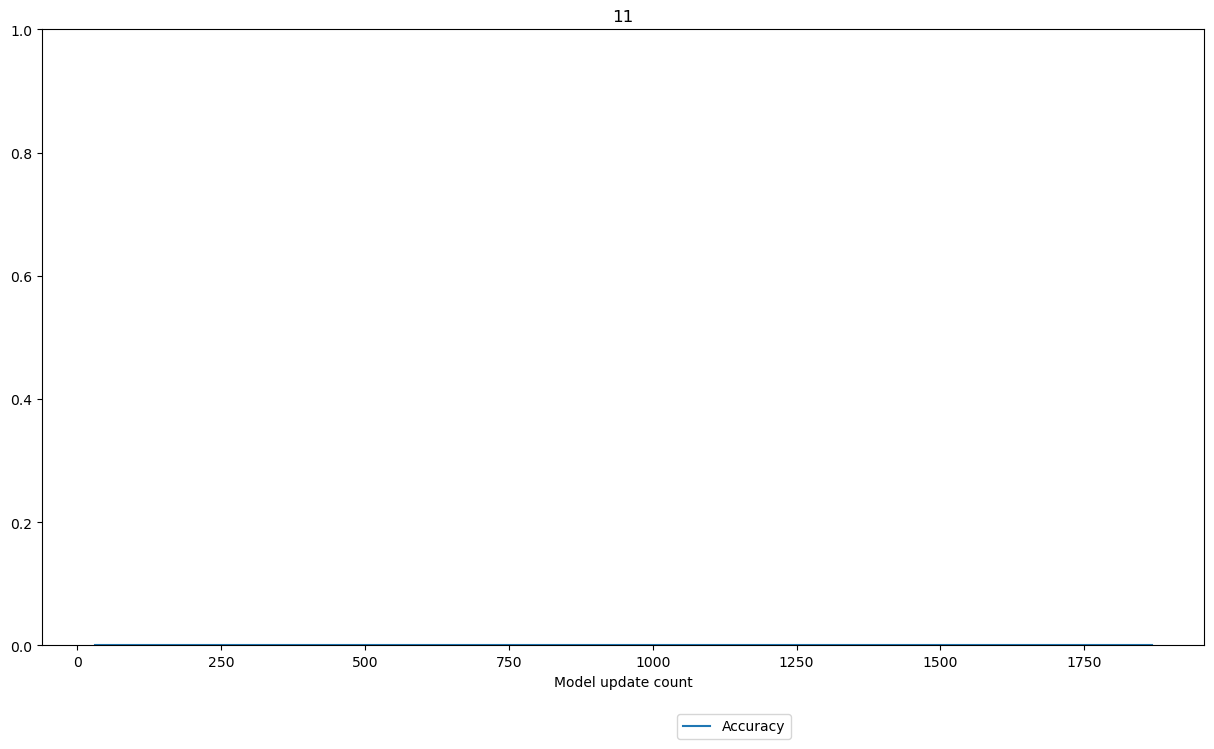

{1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {30: {'y_true': ['False', 'False', 'False', 'True', 'True', 'True', 'False', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'True'], 'y_pred': [array([[0.62799394, 0.3720061 ]], dtype=float32), array([[0.3341977, 0.6658023]], dtype=float32), array([[0.62799394, 0.3720061 ]], dtype=float32), array([[0.26199973, 0.7380003 ]], dtype=float32), array([[0.26199973, 0.7380003 ]], dtype=float32), array([[0.25687307, 0.7431269 ]], dtype=float32), array([[0.62799394, 0.3720061 ]], dtype=float32), array([[0.22377789, 0.7762221 ]], dtype=float32), array([[0.22377789, 0.7762221 ]], dtype=float32), array([[0.25370592, 0.7462941 ]], dtype=float32), array([[0.22377789, 0.7762221 ]], dtype=float32), array([[0.26199973, 0.7380003 ]], dtype=float32), array([[0.25370592, 0.7462941 ]], dtype=float32), ar

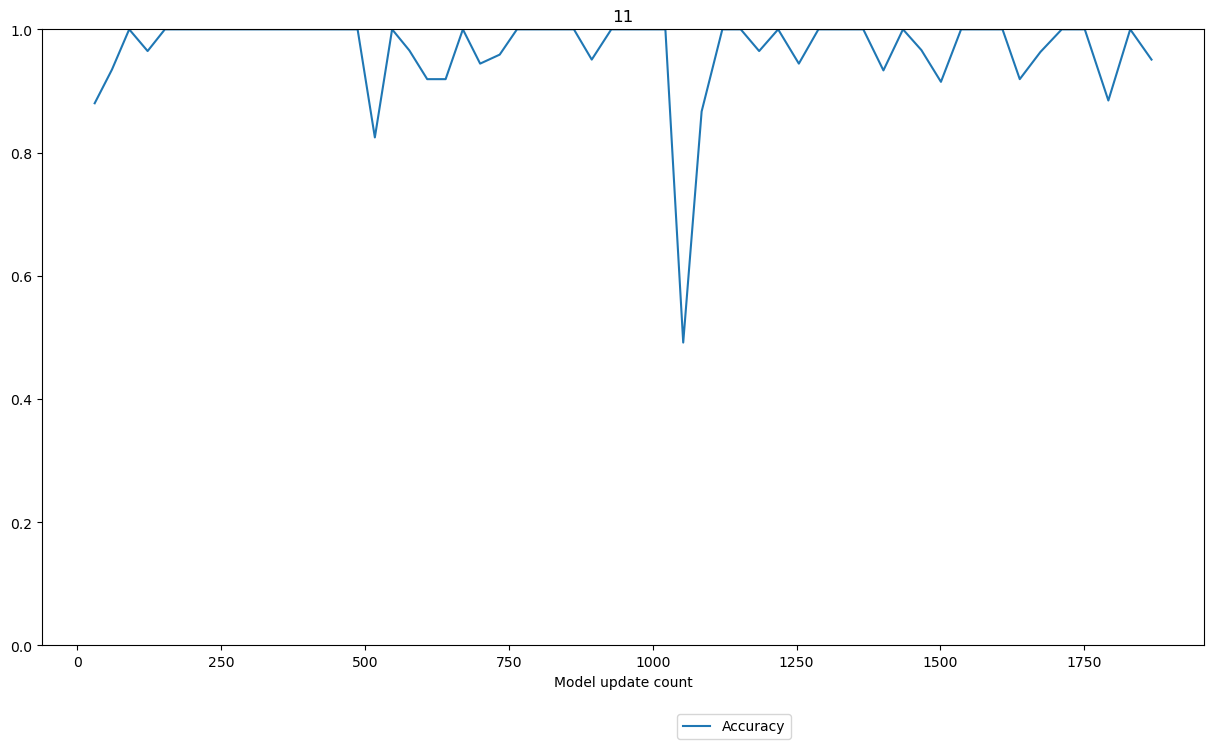

[{0: 0.62799394, 1: 0.3720061}, {0: 0.3341977, 1: 0.6658023}, {0: 0.62799394, 1: 0.3720061}, {0: 0.26199973, 1: 0.7380003}, {0: 0.26199973, 1: 0.7380003}, {0: 0.25687307, 1: 0.7431269}, {0: 0.62799394, 1: 0.3720061}, {0: 0.22377789, 1: 0.7762221}, {0: 0.22377789, 1: 0.7762221}, {0: 0.25370592, 1: 0.7462941}, {0: 0.22377789, 1: 0.7762221}, {0: 0.26199973, 1: 0.7380003}, {0: 0.25370592, 1: 0.7462941}, {0: 0.28957605, 1: 0.71042395}, {0: 0.22377789, 1: 0.7762221}, {0: 0.22377789, 1: 0.7762221}, {0: 0.62189984, 1: 0.37810013}, {0: 0.22377789, 1: 0.7762221}, {0: 0.22377789, 1: 0.7762221}, {0: 0.22377789, 1: 0.7762221}, {0: 0.22377789, 1: 0.7762221}, {0: 0.25370592, 1: 0.7462941}, {0: 0.26199973, 1: 0.7380003}, {0: 0.22377789, 1: 0.7762221}, {0: 0.22377789, 1: 0.7762221}, {0: 0.22377789, 1: 0.7762221}, {0: 0.25687307, 1: 0.7431269}, {0: 0.25687307, 1: 0.7431269}, {0: 0.62799394, 1: 0.3720061}, {0: 0.22377789, 1: 0.7762221}]
[{0: 0.20179373, 1: 0.79820627}, {0: 0.69298685, 1: 0.30701315}, {0:

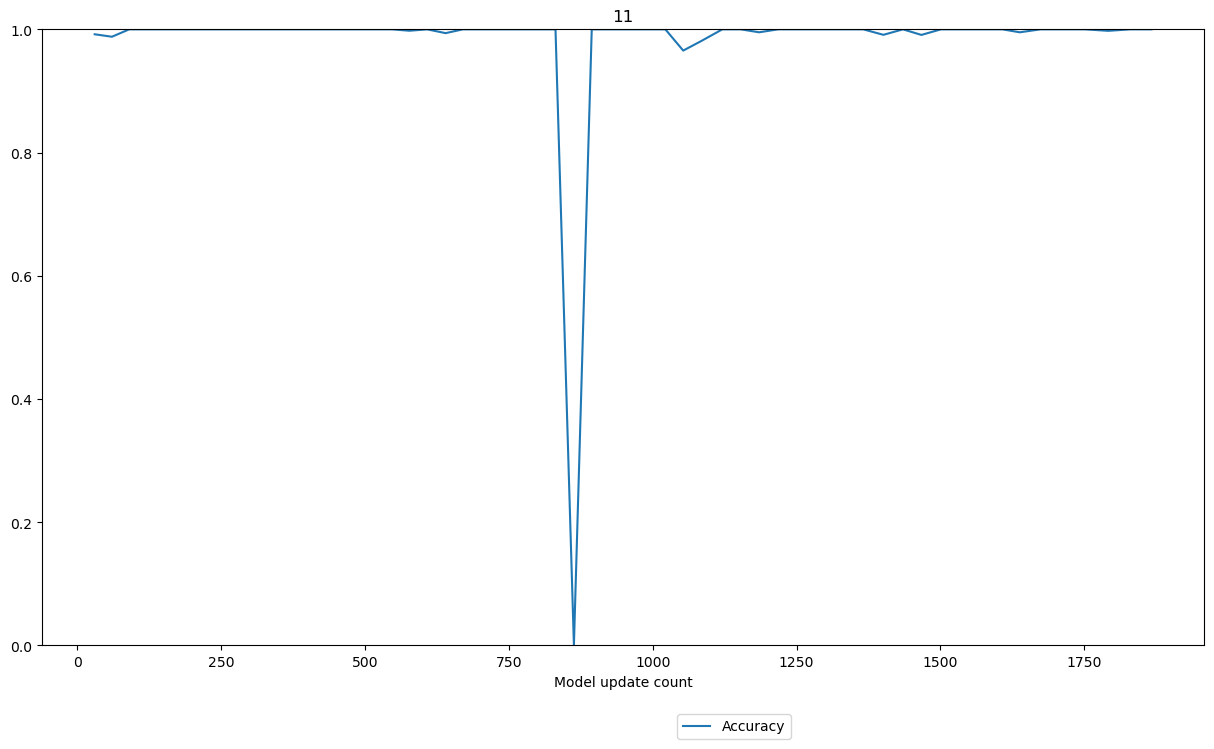

12
{1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {35: {'y_true': ['False', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True'], 'y_pred': [array([[0.34345096, 0.65654904]], dtype=float32), array([[0.25632268, 0.7436773 ]], dtype=float32), array([[0.25632268, 0.7436773 ]], dtype=float32), array([[0.25190103, 0.74809897]], dtype=float32), array([[0.2159704, 0.7840296]], dtype=float32), array([[0.2159704, 0.7840296]], dtype=float32), array([[0.25485283, 0.74514717]], dtype=float32), array([[0.2159704, 0.7840296]], dtype=float32), array([[0.2199645, 0.7800355]], dtype=float32), array([[0.21863335, 0.78136665]], dtype=float32), array([[0.25485283, 0.74514717]], dtype=float32), array([[0.2159704, 0.7840296]], dtype=float32), array([[0.2159704, 0.7840296]], dtype=float32), array

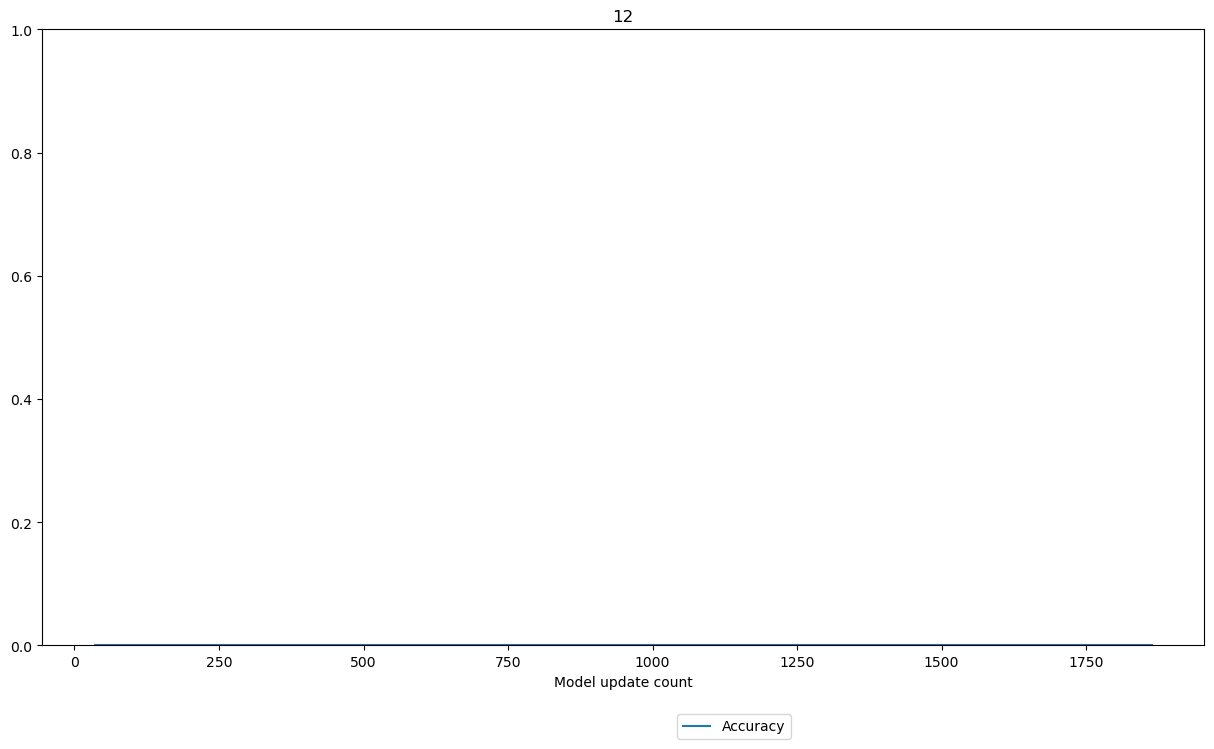

{1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {35: {'y_true': ['False', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True'], 'y_pred': [array([[0.34345096, 0.65654904]], dtype=float32), array([[0.25632268, 0.7436773 ]], dtype=float32), array([[0.25632268, 0.7436773 ]], dtype=float32), array([[0.25190103, 0.74809897]], dtype=float32), array([[0.2159704, 0.7840296]], dtype=float32), array([[0.2159704, 0.7840296]], dtype=float32), array([[0.25485283, 0.74514717]], dtype=float32), array([[0.2159704, 0.7840296]], dtype=float32), array([[0.2199645, 0.7800355]], dtype=float32), array([[0.21863335, 0.78136665]], dtype=float32), array([[0.25485283, 0.74514717]], dtype=float32), array([[0.2159704, 0.7840296]], dtype=float32), array([[0.2159704, 0.7840296]], dtype=float32), array([[

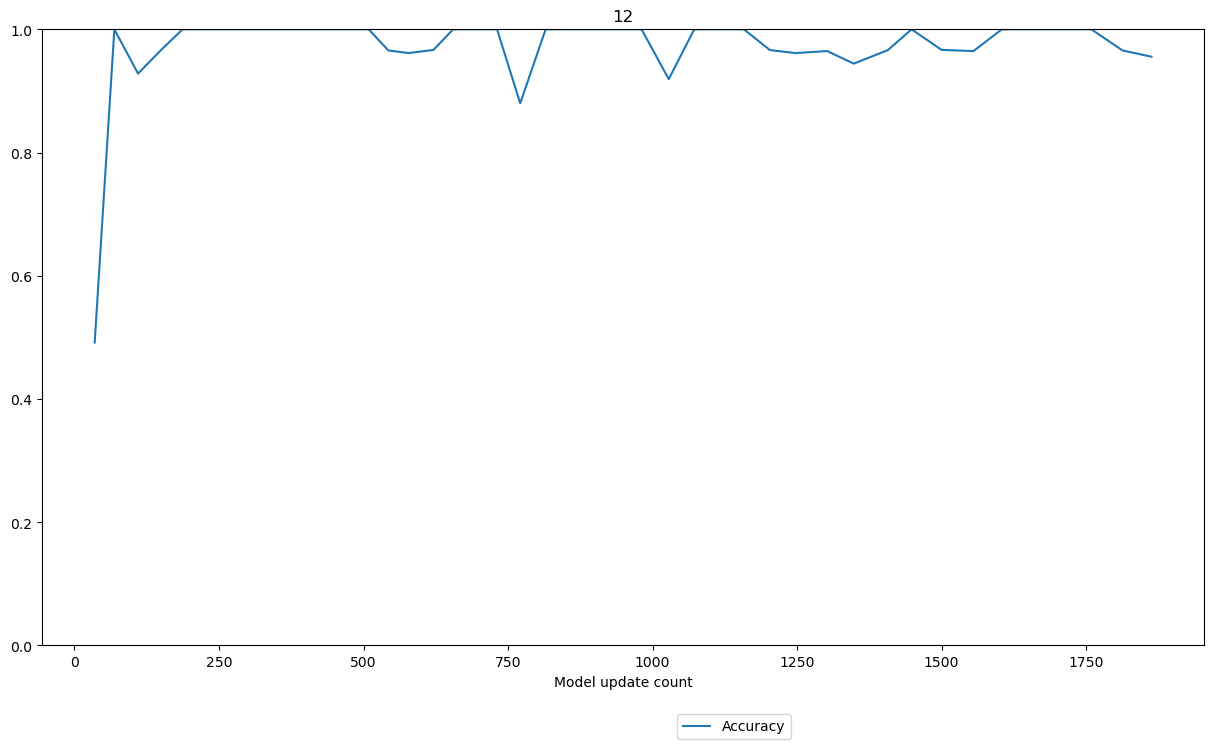

[{0: 0.34345096, 1: 0.65654904}, {0: 0.25632268, 1: 0.7436773}, {0: 0.25632268, 1: 0.7436773}, {0: 0.25190103, 1: 0.74809897}, {0: 0.2159704, 1: 0.7840296}, {0: 0.2159704, 1: 0.7840296}, {0: 0.25485283, 1: 0.74514717}, {0: 0.2159704, 1: 0.7840296}, {0: 0.2199645, 1: 0.7800355}, {0: 0.21863335, 1: 0.78136665}, {0: 0.25485283, 1: 0.74514717}, {0: 0.2159704, 1: 0.7840296}, {0: 0.2159704, 1: 0.7840296}, {0: 0.25632268, 1: 0.7436773}, {0: 0.2159704, 1: 0.7840296}, {0: 0.2159704, 1: 0.7840296}, {0: 0.2159704, 1: 0.7840296}, {0: 0.2159704, 1: 0.7840296}, {0: 0.25485283, 1: 0.74514717}, {0: 0.25632268, 1: 0.7436773}, {0: 0.2159704, 1: 0.7840296}, {0: 0.2159704, 1: 0.7840296}, {0: 0.2159704, 1: 0.7840296}, {0: 0.25190103, 1: 0.74809897}, {0: 0.25190103, 1: 0.74809897}, {0: 0.2159704, 1: 0.7840296}, {0: 0.2159704, 1: 0.7840296}, {0: 0.25485283, 1: 0.74514717}, {0: 0.2159704, 1: 0.7840296}, {0: 0.25190103, 1: 0.74809897}]
[{0: 0.2934419, 1: 0.7065581}, {0: 0.27536088, 1: 0.7246391}, {0: 0.2100958

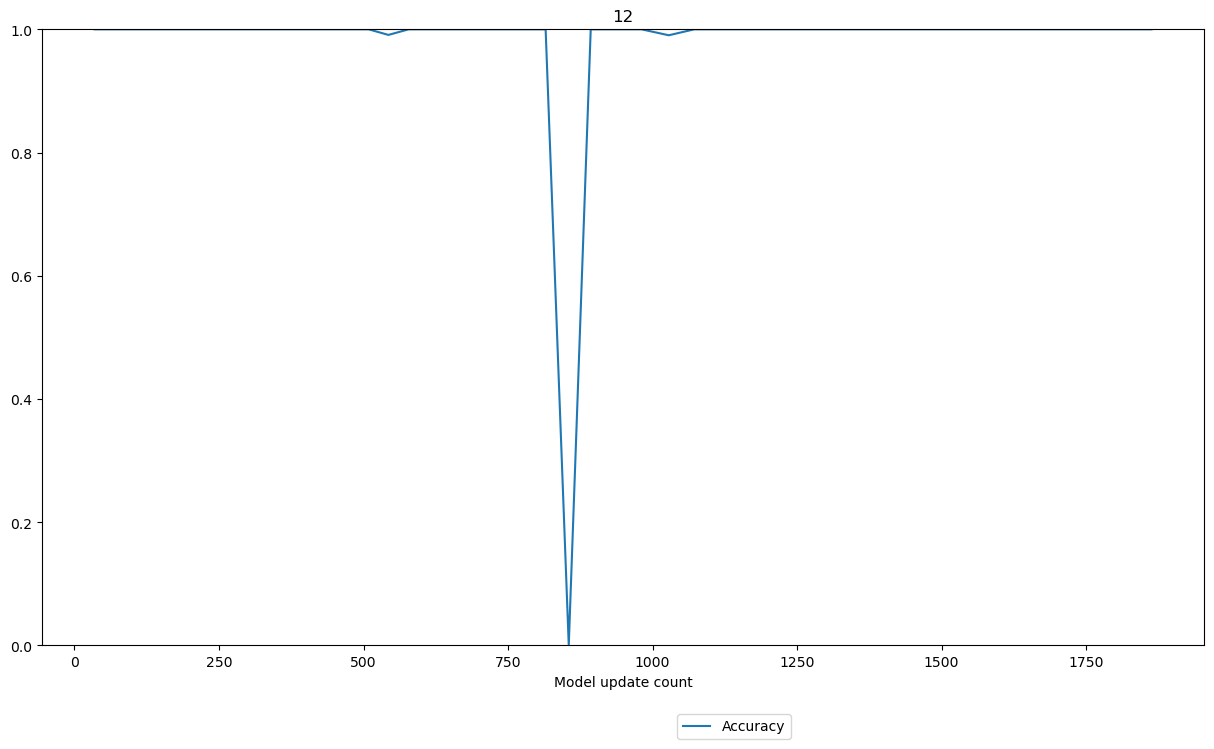

13
{1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {36: {'y_true': ['True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True'], 'y_pred': [array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dt

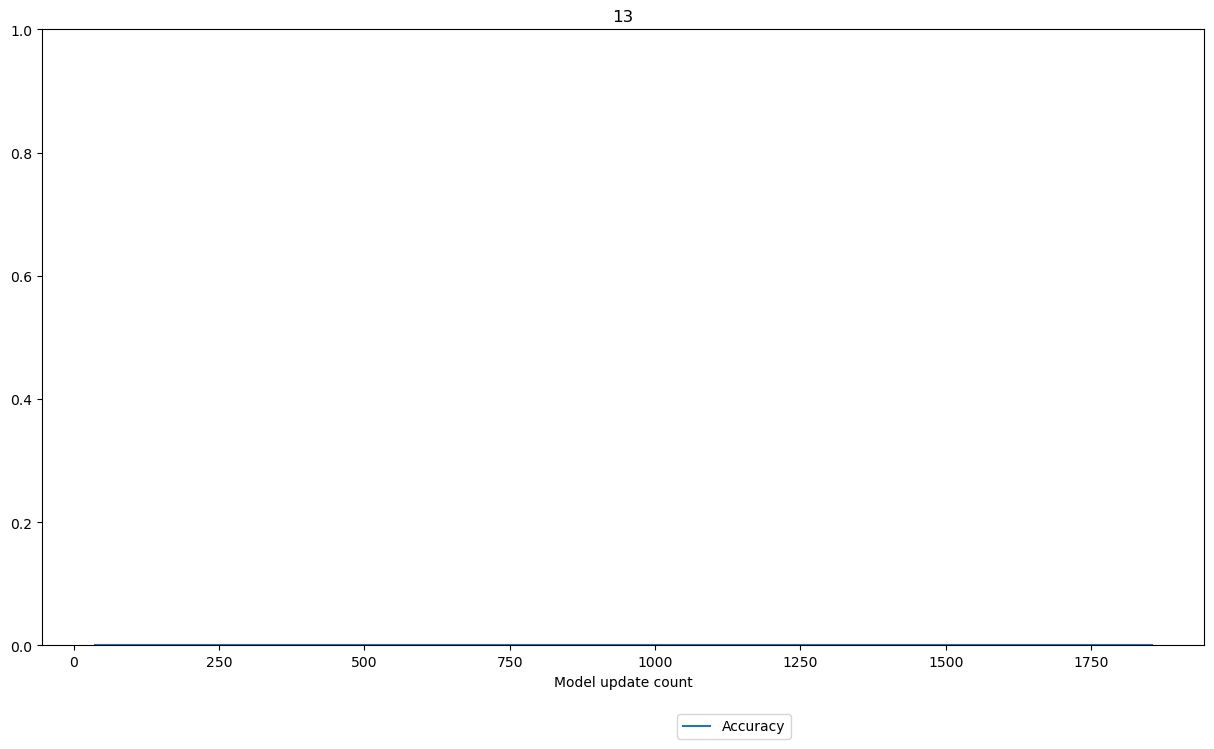

{1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {36: {'y_true': ['True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True'], 'y_pred': [array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype

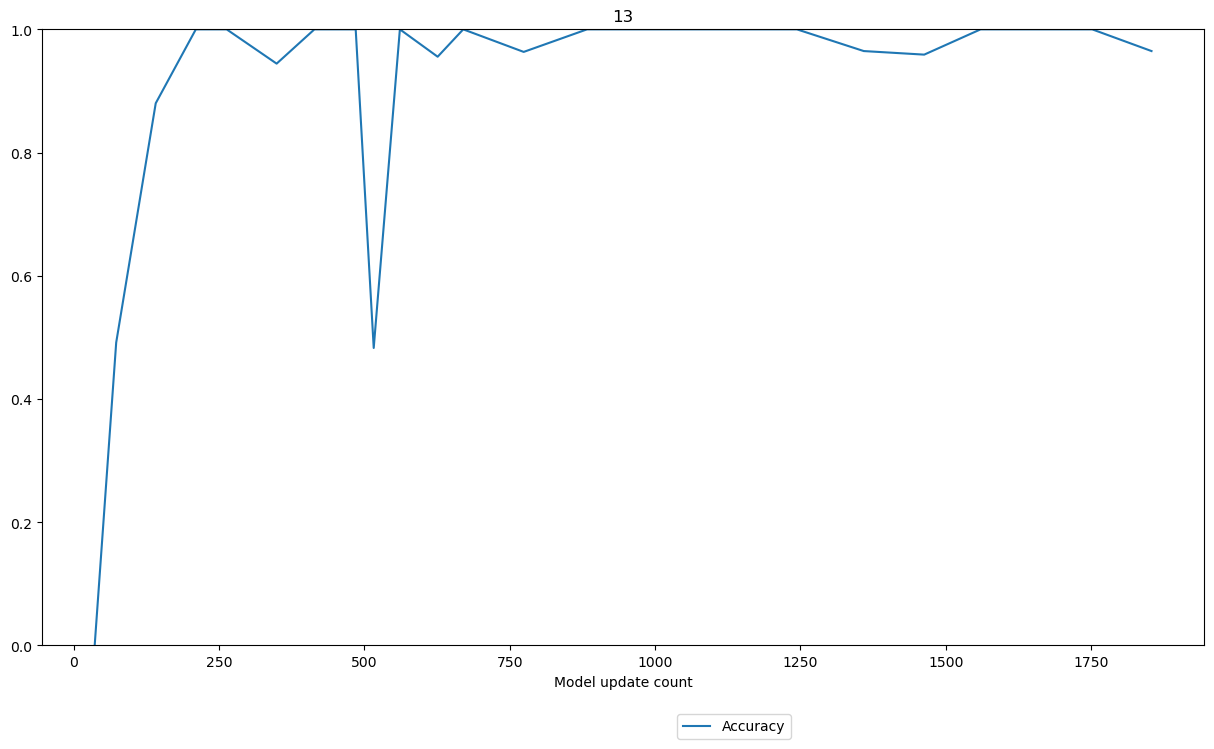

[{0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}]
[{0: 0.19813454, 1: 0.80186546}, {0: 0.

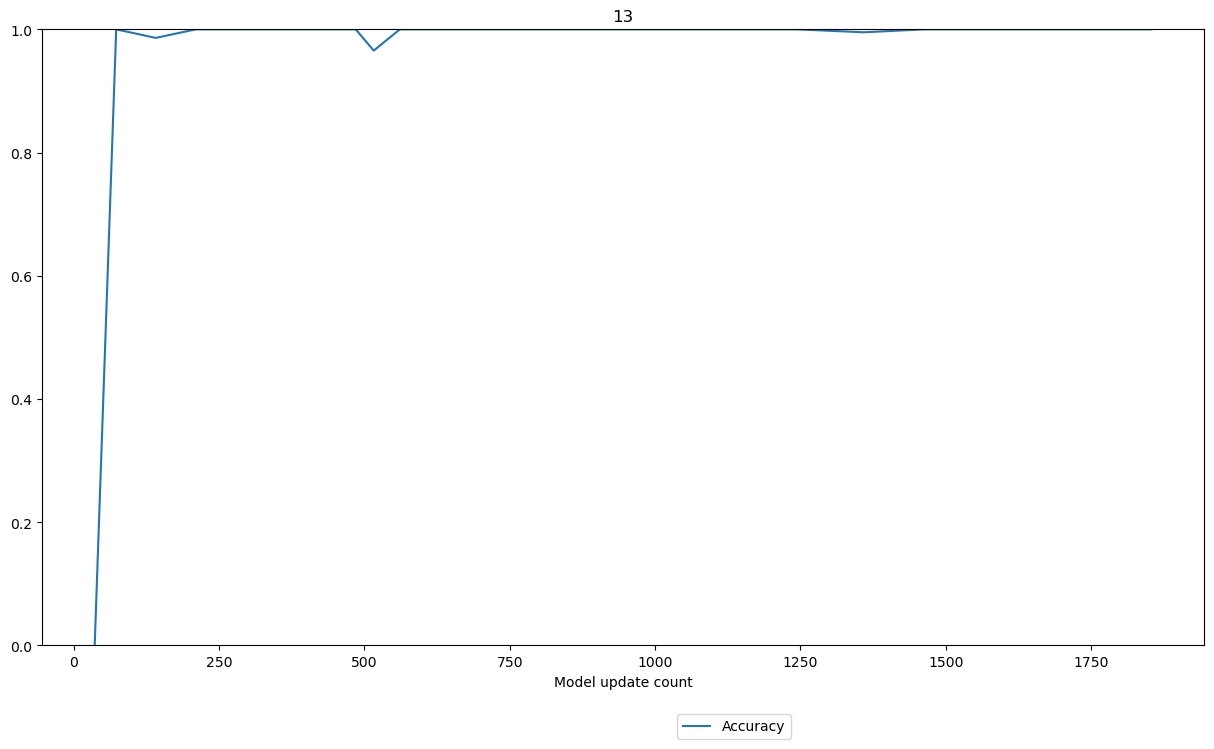

14
{1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {76: {'y_true': ['True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True'], 'y_pred': [array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.210200

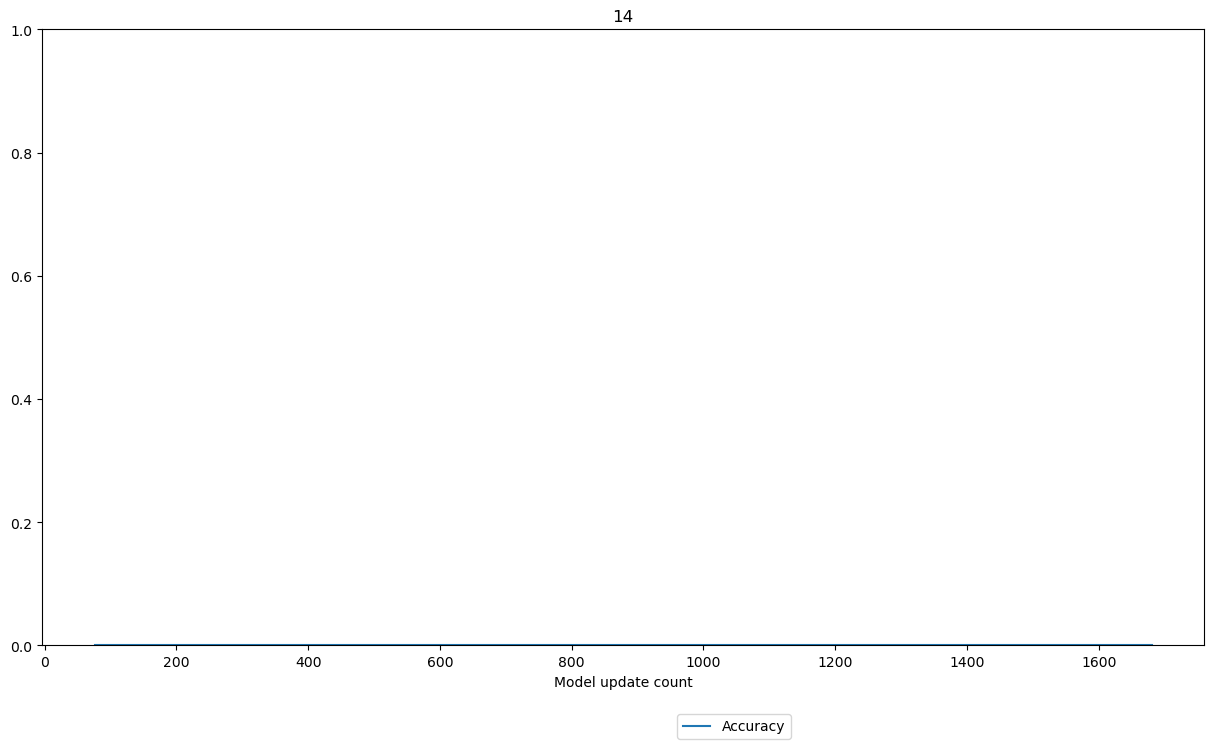

{1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {76: {'y_true': ['True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True'], 'y_pred': [array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]

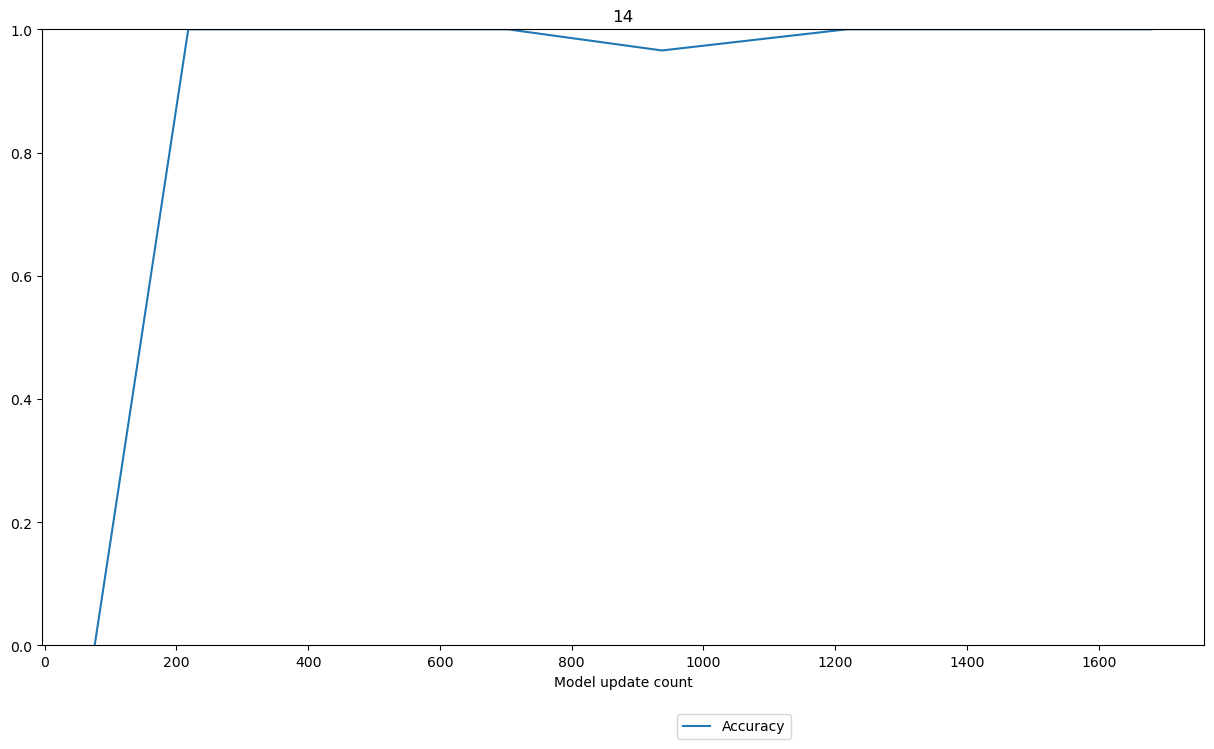

[{0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}, {0: 0.78979945, 1: 0.21020055}]
[{0: 0.20236403, 1: 0.797636}, {0: 0.20

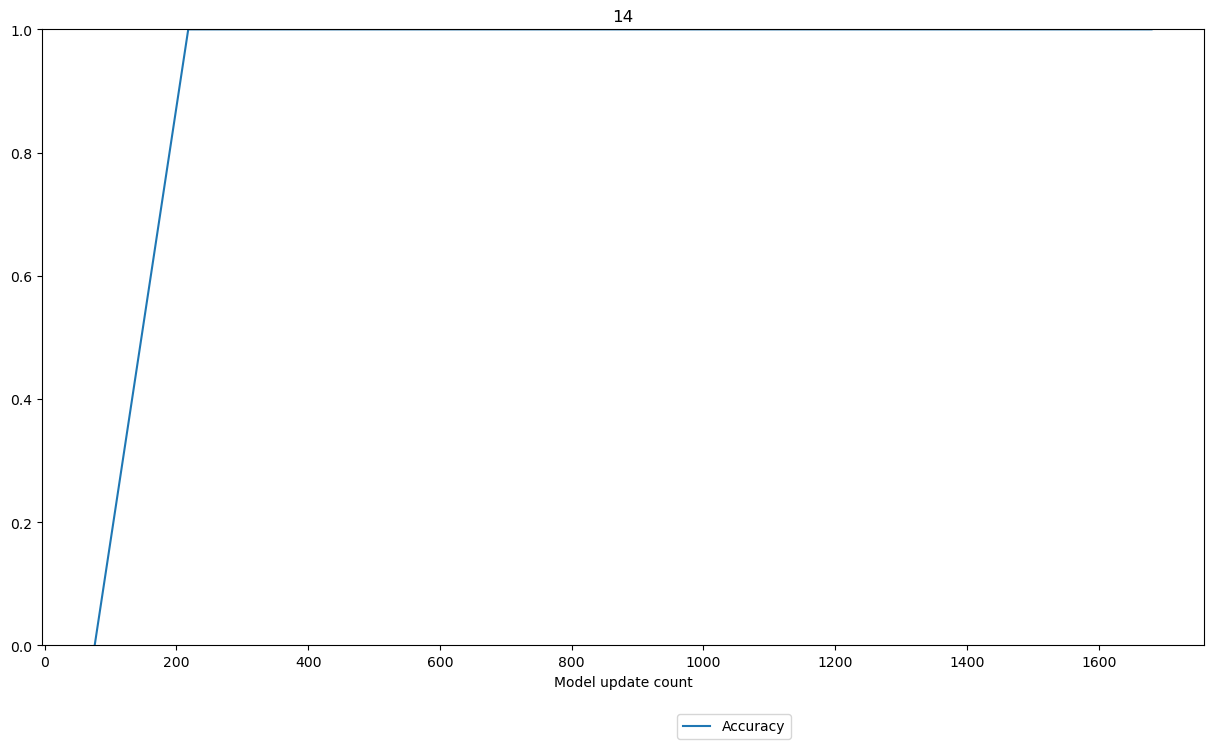

15
{1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {591: {'y_true': ['False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False'], 'y_pred': [array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype

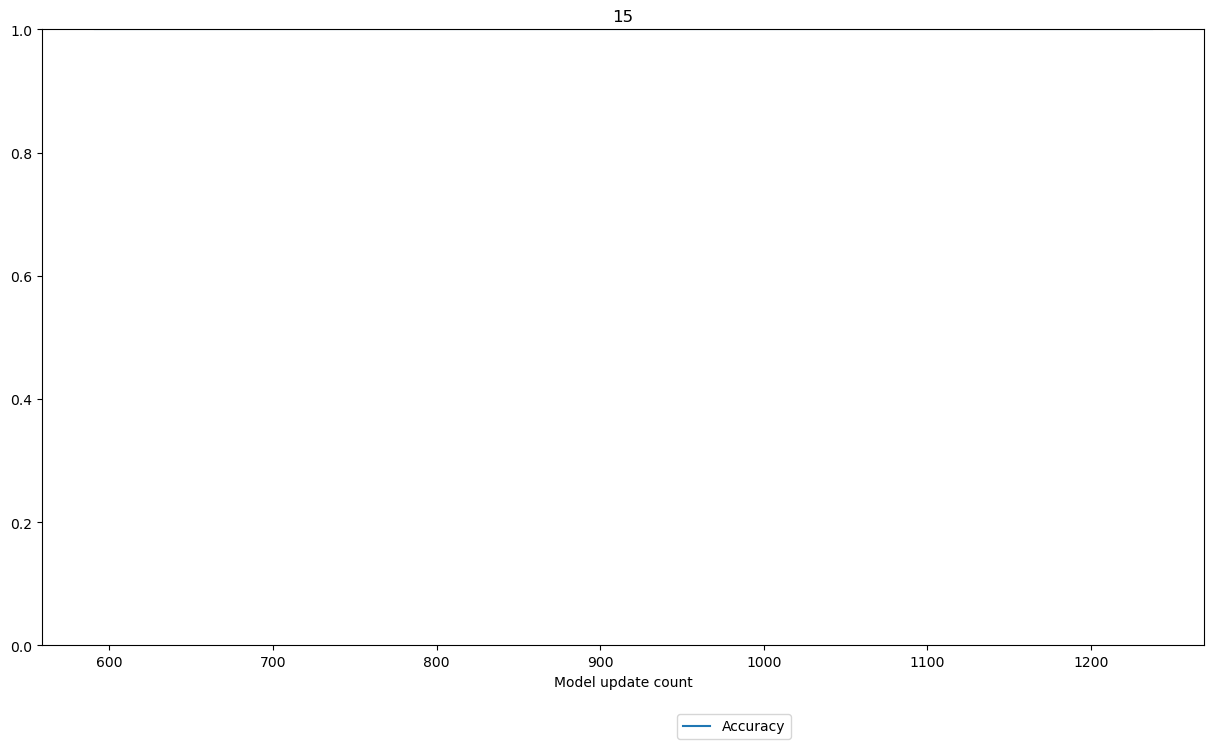

{1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {591: {'y_true': ['False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False'], 'y_pred': [array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=float32), array([[0.78979945, 0.21020055]], dtype=fl

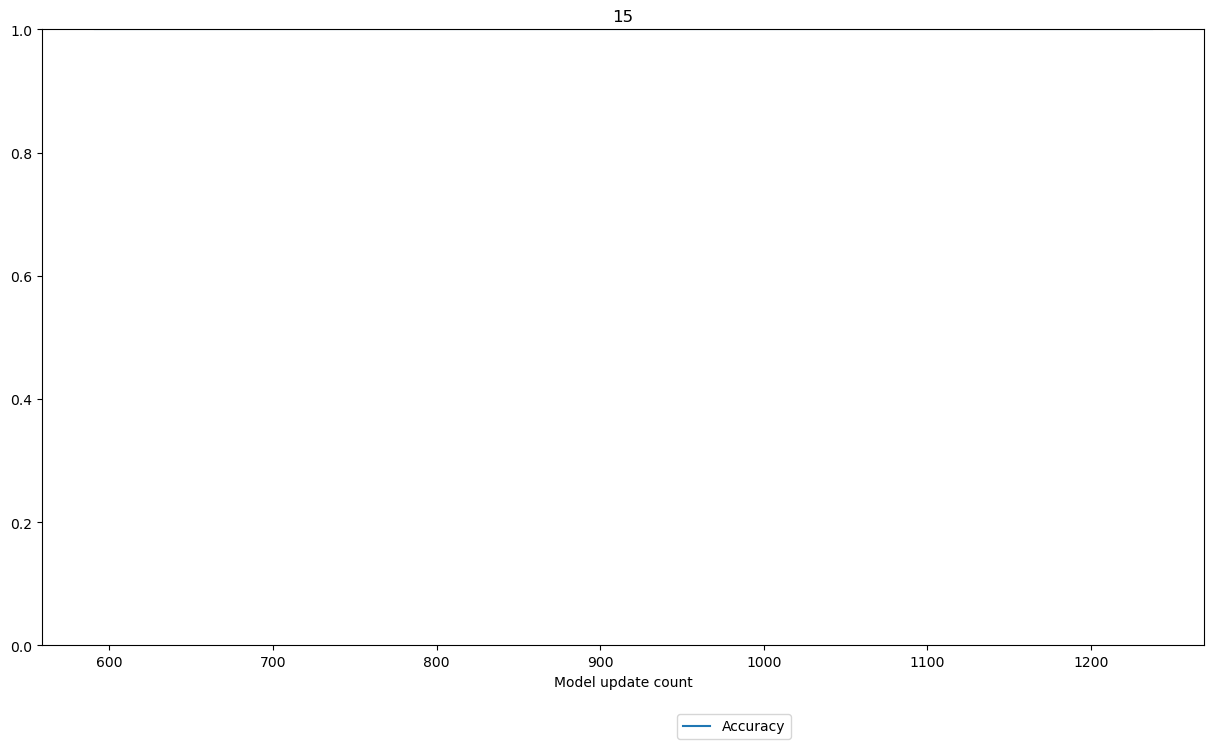

[{'False': 0.78979945, 'True': 0.21020055}, {'False': 0.78979945, 'True': 0.21020055}, {'False': 0.78979945, 'True': 0.21020055}, {'False': 0.78979945, 'True': 0.21020055}, {'False': 0.78979945, 'True': 0.21020055}, {'False': 0.78979945, 'True': 0.21020055}, {'False': 0.78979945, 'True': 0.21020055}, {'False': 0.78979945, 'True': 0.21020055}, {'False': 0.78979945, 'True': 0.21020055}, {'False': 0.78979945, 'True': 0.21020055}, {'False': 0.78979945, 'True': 0.21020055}, {'False': 0.78979945, 'True': 0.21020055}, {'False': 0.78979945, 'True': 0.21020055}, {'False': 0.78979945, 'True': 0.21020055}, {'False': 0.78979945, 'True': 0.21020055}, {'False': 0.78979945, 'True': 0.21020055}, {'False': 0.78979945, 'True': 0.21020055}, {'False': 0.78979945, 'True': 0.21020055}, {'False': 0.78979945, 'True': 0.21020055}, {'False': 0.78979945, 'True': 0.21020055}, {'False': 0.78979945, 'True': 0.21020055}, {'False': 0.78979945, 'True': 0.21020055}, {'False': 0.78979945, 'True': 0.21020055}, {'False': 

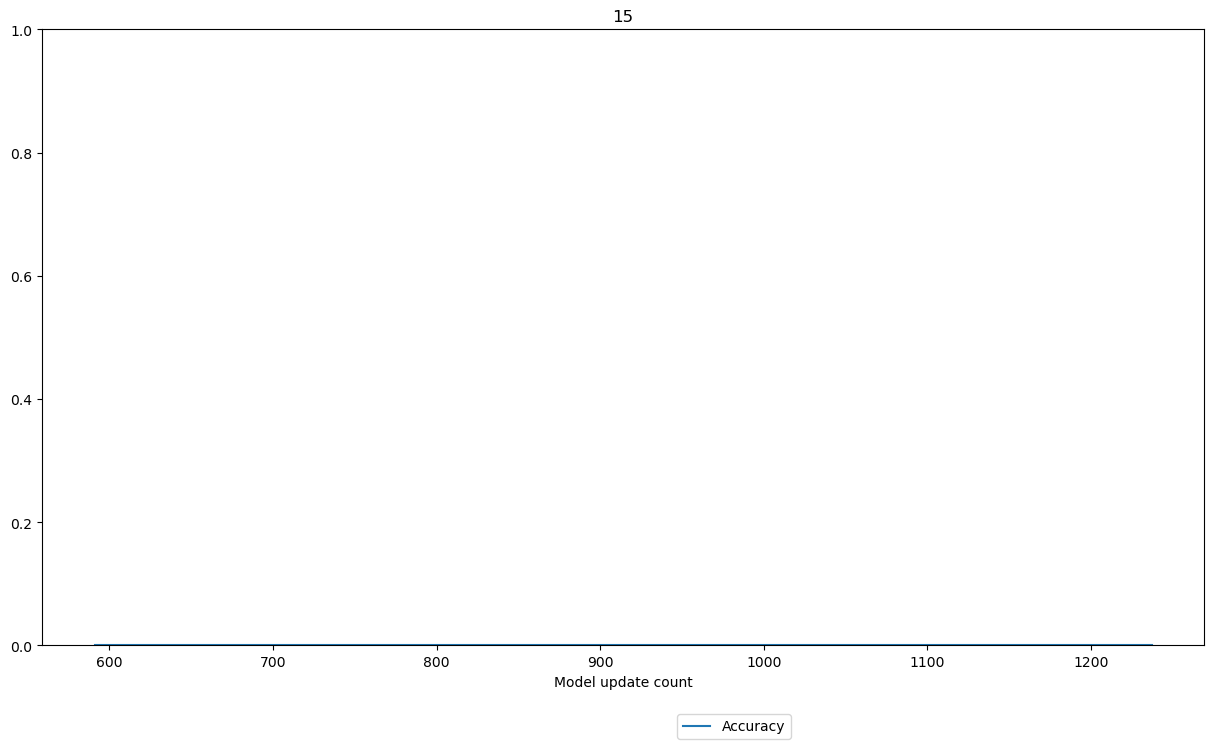

In [42]:
'''
Before test and training streaming event predictive monitoring, grace period is preceded to initialize model by prefix length
and obtain feature matrix to transform future events
'''



for maximum_prefix in range(1, maximum_prefixs+1):
    print(maximum_prefix)
    performance_measure_type = 'Accuracy'

    dataset_loc = '../DATA/logs/'+ dataset_label +'.csv'
    try:
        os.makedirs('../result/%s'%(dataset_label))
    except:
        pass

    # Set streaming classifier
    classifier = 'xgb'
    if classifier == 'xgb':
        streaming_classifier = xgb.XGBClassifier(n_estimators = 100, learning_rate=0.01, verbosity =0)

    streaming_db ={}
    training_models ={}
    test_cases = deque()
    feature_matrix ={}

    casecount = 0
    rowcounter = 0
    running_case = 0
    prediction_result = dict()
    for i in range(1, maximum_prefix+1): prediction_result[i] = {}
    finished_caseid = set()
    
    # Sliding window for training setting
    window_size = 100
    test_size = 30
    training_windows = sliding_window.training_window(window_size,test_size)
    training_models['prefix_%s'%(maximum_prefix)] = [streaming_classifier, 0]
    
    dataset = stream.iter_csv(
            dataset_loc
            )
    totallength = len(list(dataset))


    dataset = stream.iter_csv(
                dataset_loc,
                target='outcome'
                )
    enctype = 'Index-base'
    
    cdhappend ={}
    for i in range(1, maximum_prefix+1): cdhappend[i] = 0

    for x,y in dataset:
        rowcounter +=1
        # Event stream change dictionary keys
        x = utils.dictkey_chg(x, key_pair)

        if dataset_label !='bpic15':
            x['ts'] = x['ts'][:-4]

        x['outcome'] =y 
        # Initialize case by prefix length
        caseid = x['caseid']
        outcome = x['outcome']
    #     progress = x['progress']

        x.pop('caseid')
        x.pop('outcome')

    #     x.pop('progress')

        case_bin = prefix_bin(caseid, x)
        case_bin.set_enctype(enctype)

        if caseid not in list(streaming_db.keys()):
            case_bin.set_prefix_length(1)    
            streaming_db[caseid] = []
        elif caseid in finished_caseid:
            pass
        else:
            case_bin.set_prefix_length(len(streaming_db[caseid])+1)
            case_bin.set_prev_enc(streaming_db[caseid][-1])

        # Encode event and cases and add to DB
        case_bin.update_truelabel(outcome)   
        case_bin.update_encoded(catattrs=catatars,enctype=enctype)
        ts = case_bin.event['ts']
        streaming_db[caseid].append(case_bin)
        # Detect label appeared case 
        if outcome != '' and caseid not in finished_caseid:
            for i in streaming_db[caseid]:
                i.update_truelabel(outcome)
            finished_caseid.add(caseid)
            # Adding newly finished case to training set.    
            casecount +=1
            # Grace period to collect feature matrix
            case_length = len(streaming_db[caseid])
            if case_length >= maximum_prefix:
                if 'prefix_%s'%(maximum_prefix) not in list(feature_matrix.keys()):
                    feature_matrix['prefix_%s'%(maximum_prefix)]=set()

                case_length = len(streaming_db[caseid])
                if case_length >= maximum_prefix:
                    x = streaming_db[caseid][maximum_prefix-1]
                    training_windows.update_window(x)
                    update_test_cases(streaming_db[caseid], test_cases)

                    if training_windows.retraining_count == test_size:
                        x_training = pd.DataFrame.from_dict([i.encoded for i in training_windows.container])
                        for i in x_training.columns.values: x_training[i] = x_training[i].fillna(0)
                        feature_matrix['prefix_%s'%(maximum_prefix)] = x_training.columns.values
                        y_training = [i.true_label for i in training_windows.container]
                        print(y_training)
                        le = LabelEncoder()
                        y_training = le.fit_transform(y_training)
                        
                        print(y_training)
                        training_models['prefix_%s'%(maximum_prefix)][0].fit(x_training, y_training)
                        training_models['prefix_%s'%(maximum_prefix)][1] +=1
                        training_windows.reset_retraining_count()

                        '''
                        Evaluate current model with test cases
                        '''
                        prediction_result[maximum_prefix][casecount] = {}
                        y_truelist = []
                        y_predlist = []
                        for case in test_cases:
                            if len(case) >= maximum_prefix:
                                x = case[maximum_prefix-1]
                                model = training_models['prefix_%s'%(x.prefix_length)][0]
                                current_event = utils.readjustment_training(x.encoded, feature_matrix['prefix_%s'%(maximum_prefix)])
                                current_event = pd.Series(current_event).to_frame().T
                                y_pred = training_models['prefix_%s'%(x.prefix_length)][0].predict_proba(current_event)
                                y_truelist.append(x.true_label)
                                y_predlist.append(y_pred)

                        prediction_result[maximum_prefix][casecount]['y_true'] = y_truelist
                        prediction_result[maximum_prefix][casecount]['y_pred'] = y_predlist
                        if 'b1' not in caseid and cdhappend[maximum_prefix] == 0:
                            cdhappend[maximum_prefix] = casecount
                            
                            #######################EVAL#######################
####################################################################################################################################                     
    for evaluation_method in ['Accuracy', 'F1', 'ROCAUC']:
        prefix = maximum_prefix
        update_count =[]
        evaluation_list = []
        length_list = []
        for update in prediction_result[prefix].keys():
            y_true = prediction_result[prefix][update]['y_true']
            y_pred_prob_ = prediction_result[prefix][update]['y_pred']
            prediction_class = training_models['prefix_%s'%(maximum_prefix)][0].classes_
            if len(prediction_class) == 1: prediction_class = ['False', 'True']
            y_pred_prob = []
            for i in y_pred_prob_:
                y_pred_prob.append({prediction_class[0]: i[0][0], prediction_class[1]: i[0][1]})
            y_pred = [max(x, key=x.get) for x in y_pred_prob]
            update_count.append(update)

            if evaluation_method =='Accuracy':
                value = accuracy_score(y_true, y_pred)
            elif evaluation_method =='F1':
                conv_y_pred = ['True' if pred == 1 else 'False' for pred in y_pred]
                value = f1_score(y_true, conv_y_pred, average='macro')
        #             warnings.filterwarnings("ignore")

            elif evaluation_method =='ROCAUC':
                print(y_pred_prob)
                try:
                    y_pred_prob = np.array([[x[0], x[1]] for x in y_pred_prob])
                    try:
                        value = roc_auc_score(y_true, y_pred_prob[:, 1])
                    except:
                        value = 0
                except:
                    y_pred_prob = np.array([[x['False'], x['True']] for x in y_pred_prob])
                    try:
                        value = roc_auc_score(y_true, y_pred_prob[:, 1])
                    except:
                        value = 0
            evaluation_list.append(value)
        plt.figure(figsize=(15,8))
        plt.plot(update_count, evaluation_list, label = 'Accuracy')
        #     plt.plot(update_count, length_list)
        if dataset_label == 'bpic15' or dataset_label == 'bpic17':
            pass
        else:
            plt.axvline(cdhappend[prefix], color = 'black', linestyle ='--', label = 'Concept drift')
        plt.title(prefix)
        plt.xlabel('Model update count')
        plt.legend(bbox_to_anchor=(0.65, -0.1), ncol=2)
        plt.ylim(0,1)

        if os.path.exists('../img/%s/%s/%s'%(dataset_label, classifier, 'Finished cases')) == False:
            os.makedirs('../img/%s/%s/%s'%(dataset_label, classifier, 'Finished cases'))
        if os.path.exists('../result/%s/%s/%s'%(dataset_label, classifier, 'Finished cases')) == False:
            os.makedirs('../result/%s/%s/%s'%(dataset_label, classifier, 'Finished cases'))

        #print (prediction_result)

        #with open('../result/%s/%s/Finished cases/prefix_%s_%s update.pkl'%(dataset_label, classifier, prefix, evaluation_method), 'wb') as f:
        #    pkl.dump(prediction_result, f)
        #plt.savefig('../img/%s/%s/Finished cases/prefix_%s_%s update.png'%(dataset_label, classifier, prefix, evaluation_method), dpi=250)
        #plt.cla()
        #plt.clf()
        #plt.close()
        plt.show()

In [7]:
prediction_result

{1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}}